In [1]:
import numpy as np
# from matplotlib import rcParams
import matplotlib.pyplot as plt
plt.style.use('/home/groups/rwr/alpv95/util/plot.mplstyle')
import math
import itertools
#import multiprocess as mp
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
import pandas as pd
import os
import contextlib
import io
import sys
from scipy import stats
import json
import pandas as pd
from scipy.signal import detrend
import copy as cp
import csv
from matplotlib.colors import LogNorm
from astropy.time import Time

from numpy import pi, cos 
from pymultinest.solve import solve
from pymultinest.run import run
from pymultinest import Analyzer
import pymultinest
import corner
import osqp
import scipy as sp
from scipy import sparse
from skimage.measure import profile_line
from sklearn.linear_model import LinearRegression

import MulensModel as mu
from MulensModel.model import Model

%matplotlib inline

[sh02-01n70.int:30026] mca_base_component_repository_open: unable to open mca_op_avx: /share/software/user/open/openmpi/4.1.0/lib/openmpi/mca_op_avx.so: undefined symbol: ompi_op_base_module_t_class (ignored)


In [2]:
##############################
def magpat(q=0.01,d=1.0,theta=0.0,kappa=0.0,gamma=0.0,gammai=0.0,rmax=1.0,bmax=4.0,nrays=8e2):
        dx=d*np.cos(theta)
        dy=d*np.sin(theta)
        m1 = 1 / (1+q)
        m2 = q / (1 + q)
        nframes=17 # Choose an odd number; else you get divisions by zero nastiness
        npix=1000
        bframe = 2.0*float(bmax)/float(nframes)
        mag = np.zeros((npix,npix),dtype=np.float32)
        for i_frame in range(nframes):
                for j_frame in range(nframes):
                        dlx = 2.0*float(bmax)/float(nrays)/float(nframes)
                        dly = dlx
                        lx=np.linspace(-bmax+i_frame*bframe,-bmax+i_frame*bframe+bframe+dlx,nrays)
                        ly=np.linspace(-bmax+j_frame*bframe,-bmax+j_frame*bframe+bframe+dly,nrays)

                        [LX,LY]=np.meshgrid(ly,lx) # X varies on outer dimension; y on inner dimensio
                        L2 = LX**2.0+LY**2.0
                        L2q = (LX-dx)**2.0 + (LY-dy)**2.0
                        hit_x = LX- m1*LX/L2 - m2*(LX-dx)/L2q - (kappa+gamma)*LX - gammai*LY
                        hit_y = LY- m1*LY/L2 - m2*(LY-dy)/L2q - (kappa-gamma)*LY - gammai*LX
        #hit_x = L2*LX - (kappa+gamma)*LX
        #hit_y = L2*LY - (kappa-gamma)*LY

                        tp,x,y = np.histogram2d(hit_y.flatten(),hit_x.flatten(),bins=[npix,npix],range=[[-rmax,rmax],[-rmax,rmax]])
                        mag+=tp

#                         print ("\n -------------------------- \n")
#                         print ("FRAME", i_frame, j_frame)
#                         print ("XRANGE", -bmax+i_frame*bframe,-bmax+i_frame*bframe+bframe+dlx)
#                         print ("YRANGE", -bmax+j_frame*bframe,-bmax+j_frame*bframe+bframe+dly)
#                         print ("HIT RANGE", np.amin(hit_x),np.amax(hit_x), np.amin(hit_y), np.amax(hit_y))

        ext=[np.amin(x),np.amax(x),np.amin(y),np.amax(y)]
#       print "fraction of captured rays"
#        print np.sum(mag)/nrays/nrays
#       print " --------------------------------- "
        x=0.5*(x[1:]+x[:-1])
        y=0.5*(y[1:]+y[:-1])
        dx=x[2]-x[1]
        dy=y[2]-y[1]

        mag/=((2*rmax/float(npix))/(2*bmax/nrays/float(nframes)))**2.0
        #plt.imshow(mag,interpolation='none',extent=ext,cmap='gray',vmin=1.0,vmax=20.0); plt.colorbar()
        #plt.show()
        #plt.close()
        #hdr = pf.Header([('SIMPLE',True),('BITPIX',-32),('NAXIS',2),('NAXIS1',npix),('NAXIS2',npix),('CRVAL1',x[0]),('CDELT1',dx),('CRPIX1',0),('CRVAL2',y[0]),('CDELT2',dy),('CRPIX2',0), ('CUNIT1','TH_E'), ('CUNIT2','TH_E'),('CTYPE1','ANGLE'), ('CTYPE2','ANGLE'),('BMAX',bmax),('RMAX',rmax),('NRAYS',nrays), ('MRATIO',q), ('DIST',d),('BIN-ANGLE',theta),('KAPPA',kappa), ('GAMMA',gamma), ('NFRAMES',nframes), ('LTYPE','BINARY'),('AUTHOR','H.K.VEDANTHAM'),('AFFIL','CALTECH')])
        return mag #,hdr


# mag = magpat(q=0.01,d=1.0,theta=0.0,kappa=-0.1,gamma=0.0)
#pf.writeto('mybin_t.fits',mag,hdr,clobber=True)

In [3]:
name = "tony45_alpharestrict"
with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
# print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)
_, u_0, _, s, q, alpha1, k, gamma, theta, _, _, _, u_02, _, alpha2 = a.get_best_fit()["parameters"][:]

  analysing data from /home/users/alpv95/khome/SAVRot/tony45_alpharestrict/3-_1_.txt


## Tests for Mulens

In [3]:
s = 1.0
q = 0.01
alpha = 270 
k = 0.1
gamma = complex(0.05,0.0)
print(1/(1+q), q/(1+q))

0.9900990099009901 0.009900990099009901


In [4]:
mag = magpat(q=q,d=s,theta=0,kappa=k,gamma=gamma.real,gammai=gamma.imag,rmax=1.0,bmax=4.0,nrays=2000)

In [5]:
com = s * q/(1+q)

/tmp/ipykernel_30026/539834613.py:10: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
  ax2.plot(profile_line(mag, [1000,X], [-1,X],linewidth=2))


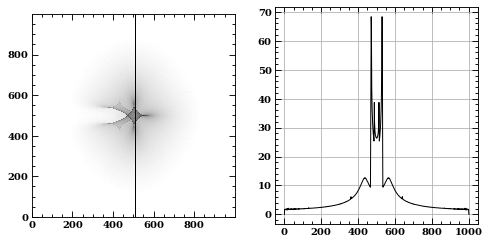

In [55]:
fig,(ax1,ax2) = plt.subplots(figsize=(8,4),ncols=2)

ax1.imshow(mag,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500),origin='lower',)
# ax1.scatter(500,500,color='r')
# ax1.scatter(com*500+500,500,color='g')

X = 510
ax1.axvline(X)

ax2.plot(profile_line(mag, [1000,X], [-1,X],linewidth=2))
ax2.grid()

In [14]:
def create_lens_vbbl(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'convergence_K': K, 
        'shear_G': G, 'rho':0.001})
    lens.set_magnification_methods([min(Day), 'vbbl', max(Day)])  
    
    return lens

In [15]:
def create_lens_ps(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'convergence_K': K, 
        'shear_G': G, 'rho':0.001})
    lens.set_magnification_methods([min(Day), 'point_source', max(Day)])  
    
    return lens

In [22]:
Day = np.arange(-1000,8000,1,dtype=float)
t_0 = 300
t_E = 500
rho = 1e-5
u_0 = -0.05
alpha = 270

In [23]:
m_1 = 1. / (1. + q)
m_2 = q / (1. + q)

lens = mu.BinaryLensWithShear(m_1, m_2, s,
                              convergence_K=k, shear_G=gamma)

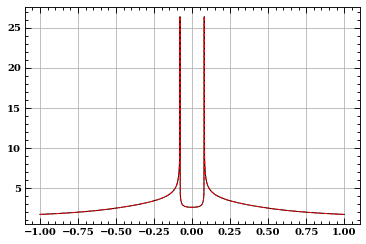

In [59]:
X =  np.linspace(-1,1,1003)
u0 = -0.1
magnif_vbbl = []
magnif_ps = []
for x in X:
    magnif_vbbl.append(lens.vbbl_magnification(u0, x, 1e-5))
    magnif_ps.append(lens.point_source_magnification(u0, x,))
plt.plot(X,magnif_vbbl)
plt.plot(X,magnif_ps,color='r')
plt.grid()

In [113]:
idx = 520
print(magnif_vbbl[idx], X[idx])

6.480196704201193 0.03792415169660668


In [26]:
idx = 440
print(magnif_vbbl[idx], X[idx])

14.540055161649246 -0.1191191191191191


/home/users/alpv95/.local/lib/python3.9/site-packages/MulensModel-2.1.15-py3.9-linux-x86_64.egg/MulensModel/model.py:1128: UserWarning: magnification() will be deprecated in favor of get_magnification()
  warnings.warn('magnification() will be deprecated in ' +
/home/users/alpv95/.local/lib/python3.9/site-packages/MulensModel-2.1.15-py3.9-linux-x86_64.egg/MulensModel/magnificationcurve.py:185: UserWarning: no finite-source method is set
  warnings.warn('no finite-source method is set', UserWarning)
/home/users/alpv95/.local/lib/python3.9/site-packages/MulensModel-2.1.15-py3.9-linux-x86_64.egg/MulensModel/model.py:1128: UserWarning: magnification() will be deprecated in favor of get_magnification()
  warnings.warn('magnification() will be deprecated in ' +


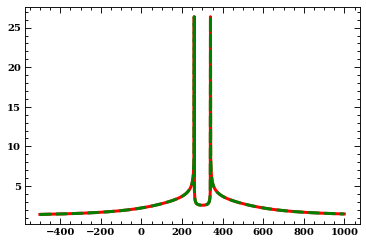

In [20]:
Day = np.arange(-500,1000,1,dtype=float)
fig,ax1 = plt.subplots()
lens_vbbl = create_lens_vbbl(Day, t_0,u_0,t_E,s,q,alpha,rho, k, gamma)
lens_psK = create_lens_ps(Day, t_0,u_0,t_E,s,q,alpha, rho, k, gamma)
ax1.plot(Day, lens_psK.magnification(Day),linewidth=3,color='r')
ax1.plot(Day, lens_vbbl.magnification(Day),linewidth=3,color='g',ls='--')

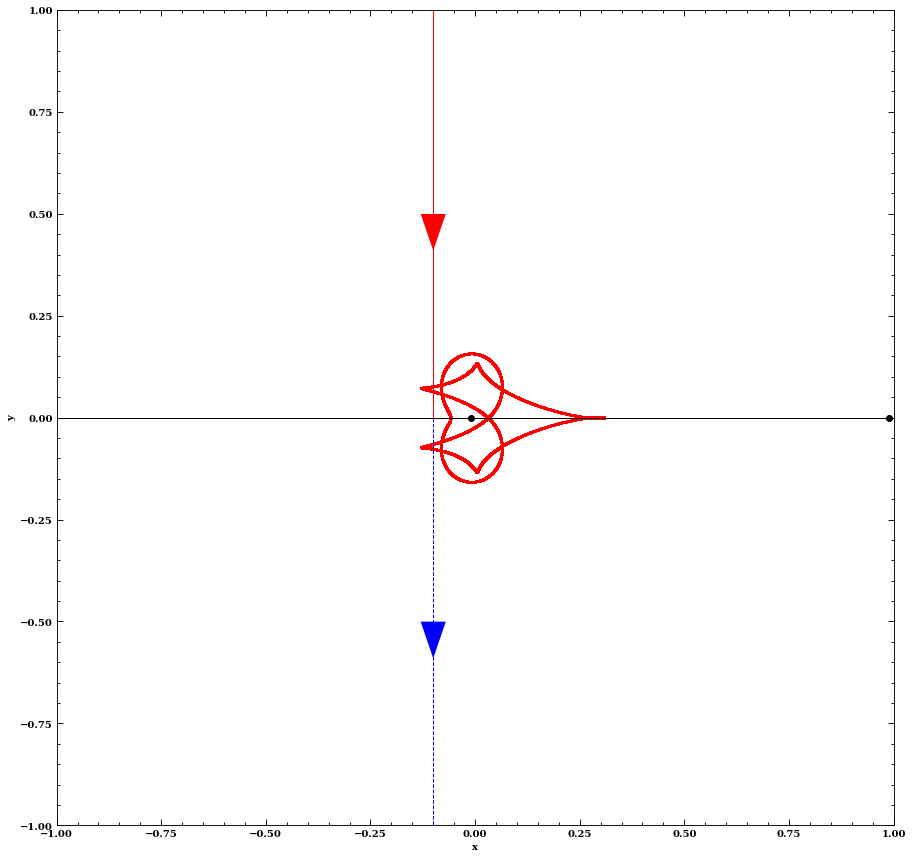

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
name = "caustic"
square = 1
ax.set_xlim(-square,square)
ax.set_ylim(-square,square)
ax.set_xlabel("x", fontweight="bold")
ax.set_ylabel("y", fontweight="bold")
lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')

ax.scatter([-q*s/(1+q), s/(1+q)],[0,0])
ax.axhline(0)

In [105]:
mag2 = magpat(q=q,d=s,theta=0,kappa=k,gamma=0*np.cos(theta),gammai=0*np.sin(theta))

In [166]:
mag1 = magpat(q=q,d=s,theta=0,kappa=k,gamma=gamma*np.cos(theta),gammai=gamma*np.sin(theta))

In [7]:
u0 = u_0
alpha = np.deg2rad(alpha1)
m = np.tan(alpha)
c = (0 + u0) - m*0
line = lambda x: m*x + c

In [152]:
u0 = u_02
alpha = np.deg2rad(alpha2)
m2 = np.tan(alpha)
c = (0 + u0) - m2*0
line2 = lambda x: m2*x + c

In [129]:
u0 = u_0
alpha = np.deg2rad(alpha1)
m_array = np.tan(alpha)
heuristic = 2.2
c_array = (500 + 500*heuristic*u0*np.sin(alpha)) - m_array*(500 - 500*heuristic*u0*np.cos(alpha))
print(c_array)
line_array = lambda x: m_array*(x) + c_array

-716.7487242745366


In [102]:
m_array

2.5550299960606906

(400, 800)

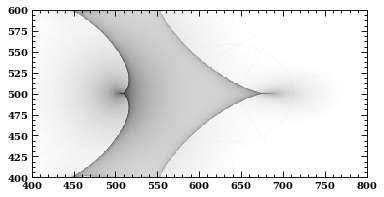

In [97]:
plt.imshow(mag2,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500),origin='lower',)
plt.ylim(400,600)
plt.xlim(400,800)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.


/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


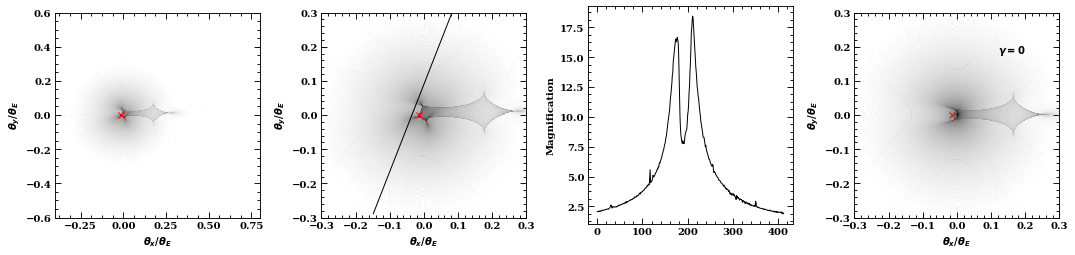

In [177]:
name="caustic_detail"
extenter = 1.63
# shift = 

fig,(ax1,ax2,ax3,ax4) = plt.subplots(figsize=(18,4),ncols=4,gridspec_kw={"wspace":0.3})
# lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
# lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=False, color='blue')

ax1.imshow(mag1,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500), 
           extent=[-extenter,extenter,-extenter,extenter],origin='lower')
ax1.plot(np.linspace(-1,1,100), line_array(np.linspace(-1,1,100)))
ax1.set_ylim(-0.6,0.6)
ax1.set_xlim(-0.4,0.8)
ax1.set_xlabel(r"$\theta_x / \theta_E$")
ax1.set_ylabel(r"$\theta_y / \theta_E$")
ax1.scatter([-q*s/(1+q), s/(1+q)],[0,0],marker='x',color='r')


ax2.imshow(mag1,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500),
          extent=[-extenter, extenter,-extenter,extenter],origin='lower')
ax2.plot((np.linspace(400,600,100)-500)*(extenter/500), (line_array(np.linspace(400,600,100))-500)*(extenter/500))
ax2.set_ylim(-0.3,0.3)
ax2.set_xlim(-0.3,0.3)
ax2.scatter([-q*s/(1+q), s/(1+q)],[0,0],marker='x',color='r')
ax2.set_xlabel(r"$\theta_x / \theta_E$")
ax2.set_ylabel(r"$\theta_y / \theta_E$")

ax3.plot(profile_line(mag1, [line_array(550),550], [line_array(400),400],linewidth=1))
ax3.set_ylabel(r"Magnification")

ax4.imshow(mag2,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500),
          extent=[-extenter,extenter,-extenter,extenter],origin='lower')
# ax4.plot((np.linspace(400,600,100)-500)*(1.4/500), (line_array(np.linspace(400,600,100))-500)*(1.4/500))
ax4.set_ylim(-0.3,0.3)
ax4.set_xlim(-0.3,0.3)
ax4.set_xlabel(r"$\theta_x / \theta_E$")
ax4.set_ylabel(r"$\theta_y / \theta_E$")
ax4.annotate(r"$\gamma = 0$", xy=(0.7,0.8),xycoords="axes fraction")
ax4.scatter([-q*s/(1+q), s/(1+q)],[0,0],marker='x',color='r')


plt.savefig("plots/" + name + ".pdf", format="pdf", pad_inches=0.5, bbox_inches="tight")

(400, 600)

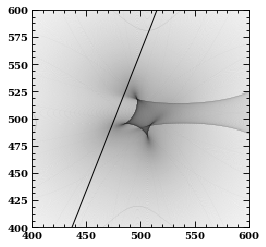

In [147]:
plt.imshow(mag1,interpolation='none',cmap='gray_r',norm=LogNorm(vmin=2, vmax=500))
plt.plot(np.linspace(400,600,100), line_array(np.linspace(400,600,100)))
plt.ylim(400,600)
plt.xlim(400,600)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
  """Entry point for launching an IPython kernel.


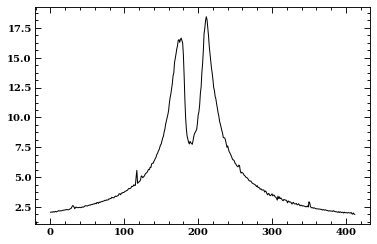

In [148]:
plt.plot(profile_line(mag1, [line_array(550),550], [line_array(400),400],linewidth=1))

In [107]:
(500 + 1000*1.3*u0*np.sin(alpha))

519.0385582416687

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


1.1149558


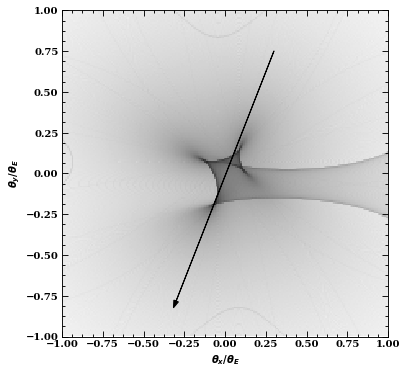

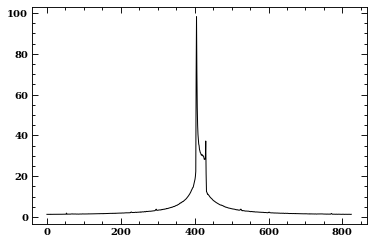

In [114]:
name = "caustics"
col = 475
fig,ax1 = plt.subplots(figsize=(6,6))

ax1.set_ylim(-1,1)
ax1.set_xlim(-1,1)
ax1.set_xlabel(r"$\theta_x / \theta_E$")
ax1.set_ylabel(r"$\theta_y / \theta_E$")
# plt.plot([0, 1000], [line(0), line(1000)], color='r', linestyle='-', linewidth=1)
ax1.arrow(0.3,line(0.3),-0.6,-0.6*m,head_width=0.03)
# ax1.arrow(0.3,line2(0.3),-0.6,-0.6*m2,head_width=0.03)
ax1.imshow(mag1,interpolation='none',cmap='gray_r',origin='lower',
           extent=[-5.0,5.0,-5.0,5.0],norm=LogNorm(vmin=2, vmax=500));# plt.colorbar()
# plt.axvline(x=col, color='red', linewidth=0.8)
# plt.figure(3)
# plt.imshow(mag2,interpolation='none',cmap='gray',vmin=1.0,vmax=20.0); plt.colorbar()
# plt.axhline(y=col,color='red', linewidth=0.8)
plt.figure(2)
plt.plot(profile_line(mag1, [line_array(350),350], [line_array(650),650],linewidth=1),'k') #[y,x]
print(min(mag1[:,col]))
# plt.savefig("plots/" + name + ".pdf", format="pdf", pad_inches=0.5, bbox_inches="tight")

In [19]:
def create_lens_ps(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'K': K, 
        'G': G})
    lens.set_magnification_methods([min(Day), 'point_source', max(Day)])  
    
    return lens

In [20]:
def create_lens_vbbl(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021, K=0.0, G=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'K': K, 
        'G': G})
    lens.set_magnification_methods([min(Day), 'vbbl', max(Day)])  
    
    return lens

If you change the range to be larger than the range which the lens object is initialized to, the 'default magnification method' is used for points outside of the initialized range. This can be set at the top of the model.py class in MulensModel source

In [17]:
Day = np.arange(-1000,8000,1,dtype=float)
t_0 = 300
u0 = 0.1
t_E = 500
K = 0.1
g = 0.01
theta = np.pi * 1/2
G = g*complex(np.cos(theta),np.sin(theta))
s = 0.9
q = 0.1
alpha = 270
rho = 0

In [146]:
from scipy.ndimage import gaussian_filter1d

TypeError: rho must be positive float, but None was provided

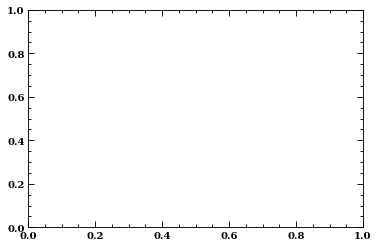

In [21]:
Day = np.arange(0,700,1,dtype=float)
fig,ax1 = plt.subplots()
lens_vbbl = create_lens_vbbl(Day, t_0,u0,t_E,s,q,alpha,rho, K, G)
lens_psK = create_lens_ps(Day, t_0,u0,t_E,s,q,alpha, rho, K, G)
ax1.plot(Day, lens_psK.magnification(Day),linewidth=3,color='r')
ax1.plot(Day, lens_vbbl.magnification(Day),linewidth=3,color='g',ls='--')
# ax1.plot(Day, gaussian_filter1d(lens_vbbl.magnification(Day),7),linewidth=3,color='g',ls='--')
# ax1.plot(Day, lens_psK.magnification(Day),linewidth=3,color='g',ls='-')

# lens_vbbl2 = create_lens_vbbl(Day, t_0,u_0,t_E,1,q,alpha,rho, K, G)
# lens_psK2 = create_lens_ps(Day, t_0,u_0,t_E,1,q,alpha,rho, K, G)
# # ax1.plot(Day, lens_psK.magnification(Day),linewidth=3,color='g')
# ax1.plot(Day, lens_vbbl2.magnification(Day),linewidth=3,color='g',ls="--")


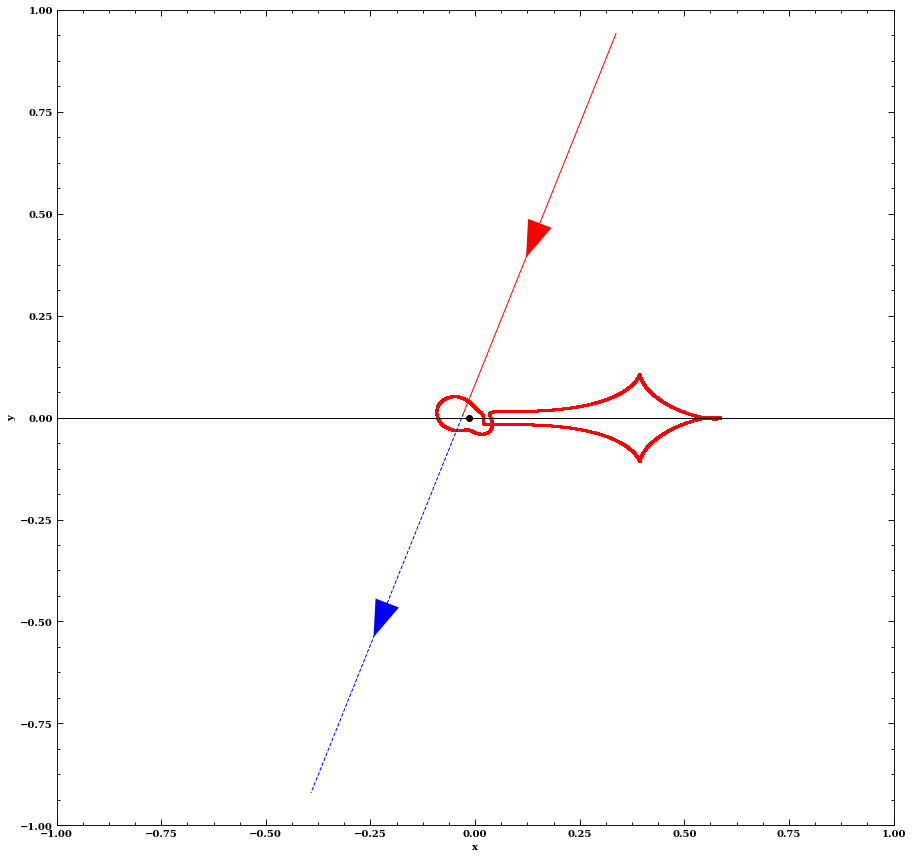

In [169]:
fig, ax = plt.subplots(figsize=(15,15))
name = "caustic"
square = 1
ax.set_xlim(-square,square)
ax.set_ylim(-square,square)
ax.set_xlabel("x", fontweight="bold")
ax.set_ylabel("y", fontweight="bold")
lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')

ax.scatter([-q*s/(1+q), s/(1+q)],[0,0])
ax.axhline(0)

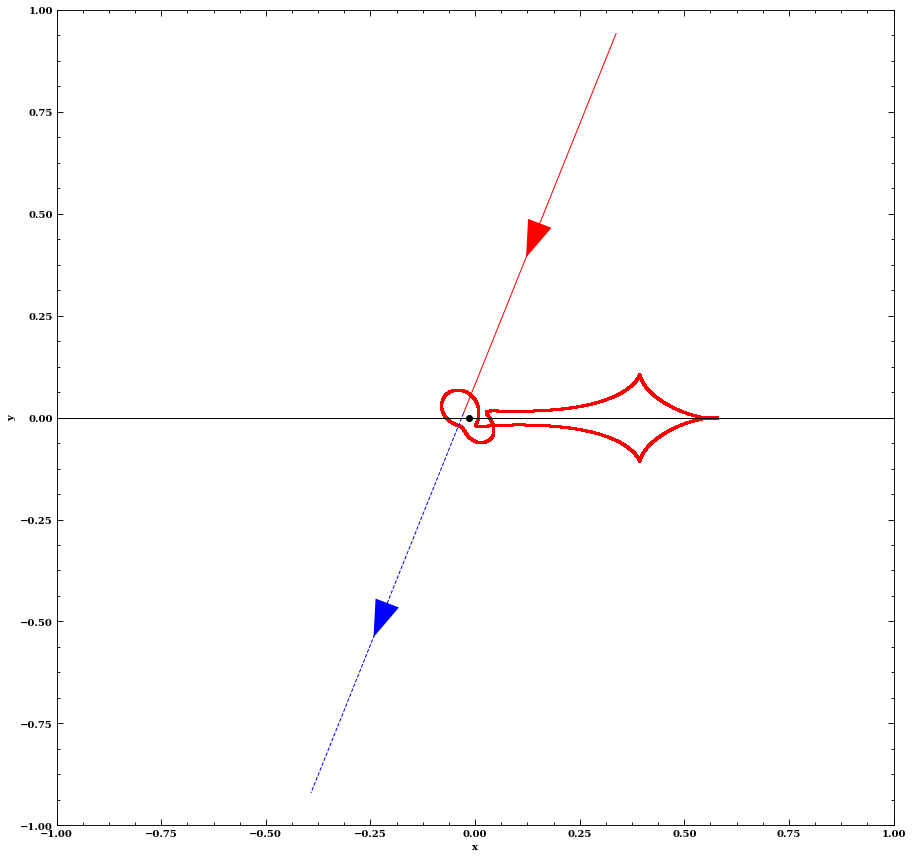

In [124]:
fig, ax = plt.subplots(figsize=(15,15))
name = "caustic"
square = 1
ax.set_xlim(-square,square)
ax.set_ylim(-square,square)
ax.set_xlabel("x", fontweight="bold")
ax.set_ylabel("y", fontweight="bold")
lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
ax.scatter([-q*s/(1+q), s/(1+q)],[0,0])
ax.axhline(0)

1.000002461480476 2.040818791286604


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0,'$x_s$')

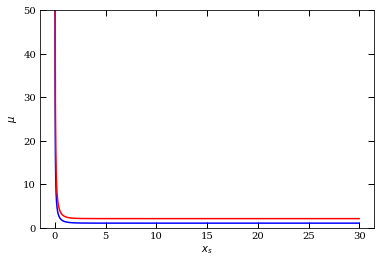

In [166]:
x_s = np.arange(0.0,30.0,0.01)
detA = lambda x, k: ((1-k)**2 - 1/x**4)**(-1)
k = 0.0
mag = []
for xs in x_s:
    x1 = (xs + np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    x2 = (xs - np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    #print(x1,x2)
    #print(1/detA(x1,k))
    mag.append(abs(detA(x1,k)) + abs(detA(x2,k)))
    
k = 0.3
mag2 = []
for xs in x_s:
    x1 = (xs + np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    x2 = (xs - np.sqrt(xs**2 + 4*(1-k))) / (2*(1-k))
    #print(x1,x2)
    #print(1/detA(x1,k))
    mag2.append(abs(detA(x1,k)) + abs(detA(x2,k)))
    
    
plt.plot(x_s, mag,"b")
plt.plot(x_s, mag2,"r")
print(np.min(mag), np.min(mag2))
plt.ylim(0,50)
plt.ylabel(r"$\mu$")
plt.xlabel(r"$x_s$")

In [102]:
np.max(lens_psK.magnification(Day))

10.037461005722324

(0, 10)

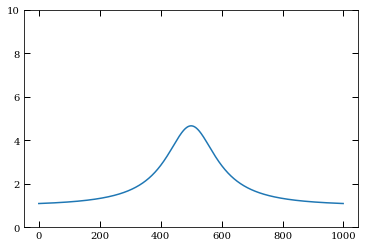

In [110]:
plt.plot(Day,lens_psK.magnification(Day))
plt.ylim(0,10)

(1, 10)

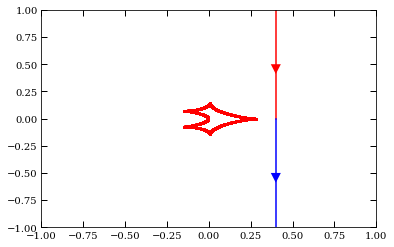

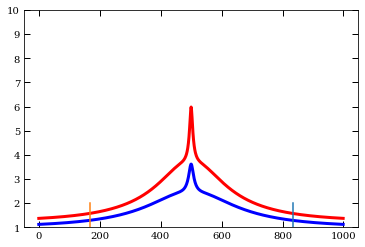

In [61]:
plt.figure(1)
square = 1.0
plt.xlim(-square,square)
plt.ylim(-square,square)
# lens_psK.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
# lens_psK.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
lens_ps1.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens_ps1.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.figure(2)
plt.plot(Day, lens_psK.magnification(Day),linewidth=3,color='r',)
plt.plot(Day, lens_ps1.magnification(Day),linewidth=3,color='b',)
plt.plot([t_0 + t_E, t_0 + t_E], [1,2])
plt.plot([t_0 - t_E, t_0 - t_E], [1,2])
plt.ylim(1,10)
# plt.xlim(580,570)

In [15]:
mag1 = magpat(q=0.0,d=1.0,theta=0.0,kappa=0.0,gamma=0.0)
mag2 = magpat(q=0.0,d=1.0,theta=0.0,kappa=0.1,gamma=0.0)
mag3 = magpat(q=0.0,d=1.0,theta=0.0,kappa=-0.1,gamma=0.0)

0.1 0.0
[-0.75845967+2.15276296j -0.95259363-0.30087842j -0.1174413 -0.27630604j
  0.04169562-0.29848929j -0.85672186-0.21413888j]
[-0.75845967+2.15276296j -0.95259363-0.30087842j -0.85672186-0.21413888j
  0.04169562-0.29848929j -0.1174413 -0.27630604j]
Number of solutions:  3
0.1 0.0
[-0.75860123+2.14997468j -0.95241684-0.30137068j -0.11782319-0.27673953j
  0.04189256-0.2989463j  -0.85638699-0.21430625j]
[-0.75860123+2.14997468j -0.95241684-0.30137068j -0.85638699-0.21430625j
  0.04189256-0.2989463j  -0.11782319-0.27673953j]
Number of solutions:  3
0.1 0.0
[-0.75874332+2.14718734j -0.95223905-0.30186437j -0.11820712-0.27717441j
  0.0420908 -0.29940433j -0.85605119-0.21447368j]
[-0.75874332+2.14718734j -0.95223905-0.30186437j -0.85605119-0.21447368j
  0.0420908 -0.29940433j -0.11820712-0.27717441j]
Number of solutions:  3
0.1 0.0
[-0.75888594+2.14440094j -0.95206025-0.3023595j  -0.1185931 -0.27761071j
  0.04229035-0.29986336j -0.85571446-0.21464119j]
[-0.75888594+2.14440094j -0.9520602

0.1 0.0
[-0.77362185+1.90576401j -0.9314839 -0.35153195j -0.16246759-0.32185249j
  0.06613476-0.34351982j -0.82258868-0.22967146j]
[-0.77362185+1.90576401j -0.9314839 -0.35153195j -0.82258868-0.22967146j
  0.06613476-0.34351982j -0.16246759-0.32185249j]
Number of solutions:  3
0.1 0.0
[-0.77382198+1.90306638j -0.93117208-0.35217432j -0.16312737-0.32244468j
  0.06650372-0.34406018j -0.82216045-0.22985393j]
[-0.77382198+1.90306638j -0.93117208-0.35217432j -0.82216045-0.22985393j
  0.06650372-0.34406018j -0.16312737-0.32244468j]
Number of solutions:  3
0.1 0.0
[-0.77402292+1.90036983j -0.93085801-0.35281861j -0.1637918 -0.32303906j
  0.06687539-0.34460124j -0.82173105-0.23003679j]
[-0.77402292+1.90036983j -0.93085801-0.35281861j -0.82173105-0.23003679j
  0.06687539-0.34460124j -0.1637918 -0.32303906j]
Number of solutions:  3
0.1 0.0
[-0.77422465+1.89767434j -0.93054168-0.35346482j -0.16446093-0.32363564j
  0.0672498 -0.345143j   -0.82130046-0.23022006j]
[-0.77422465+1.89767434j -0.9305416

0.1 0.0
[-0.79507047+1.67000138j -0.89088987-0.41646321j -0.24771666-0.3841608j
 -0.77907733-0.24948497j  0.11261255-0.39274397j]
[-0.79507047+1.67000138j -0.89088987-0.41646321j -0.77907733-0.24948497j
 -0.24771666-0.3841608j   0.11261255-0.39274397j]
Number of solutions:  3
0.1 0.0
[-0.79535993+1.66740344j -0.89021213-0.4172788j  -0.24912509-0.38497949j
 -0.77850948-0.24979022j  0.11333283-0.39328198j]
[-0.79535993+1.66740344j -0.89021213-0.4172788j  -0.77850948-0.24979022j
 -0.24912509-0.38497949j  0.11333283-0.39328198j]
Number of solutions:  3
0.1 0.0
[-0.79565063+1.66480666j -0.88952677-0.41809595j -0.25054858-0.3858008j
 -0.77793918-0.25009893j  0.11405859-0.39381875j]
[-0.79565063+1.66480666j -0.88952677-0.41809595j -0.77793918-0.25009893j
 -0.25054858-0.3858008j   0.11405859-0.39381875j]
Number of solutions:  3
0.1 0.0
[-0.79594259+1.66221105j -0.88883366-0.41891462j -0.25198739-0.38662472j
 -0.7773664 -0.2504112j   0.11478986-0.39435424j]
[-0.79594259+1.66221105j -0.88883366-

 -0.40198021-0.44320111j  0.17615677-0.42396759j]
Number of solutions:  3
0.1 0.0
[-0.8183489 +1.49349121j -0.81033784-0.47143206j -0.40592383-0.44401201j
 -0.72927675-0.28916363j  0.17734496-0.42429607j]
[-0.8183489 +1.49349121j -0.81033784-0.47143206j -0.72927675-0.28916363j
 -0.40592383-0.44401201j  0.17734496-0.42429607j]
Number of solutions:  3
0.1 0.0
[-0.81874204+1.4909743j  -0.80809399-0.47198168j -0.40997201-0.44481302j
 -0.72822014-0.29040588j  0.17854147-0.42461895j]
[-0.81874204+1.4909743j  -0.80809399-0.47198168j -0.72822014-0.29040588j
 -0.40997201-0.44481302j  0.17854147-0.42461895j]
Number of solutions:  3
0.1 0.0
[-0.81913698+1.48845856j -0.80577523-0.47250356j -0.41413124-0.44560321j
 -0.72714084-0.29169816j  0.17974635-0.42493613j]
[-0.81913698+1.48845856j -0.80577523-0.47250356j -0.72714084-0.29169816j
 -0.41413124-0.44560321j  0.17974635-0.42493613j]
Number of solutions:  3
0.1 0.0
[-0.81953373+1.485944j   -0.80337606-0.47299483j -0.41840873-0.44638158j
 -0.7260373

0.1 0.0
[-0.86178341+1.27403773j -0.82904581-0.38209887j  0.3191247 -0.41727709j
 -0.71686602-0.92231603j -0.5509686 -0.17947989j]
[-0.86178341+1.27403773j -0.71686602-0.92231603j  0.3191247 -0.41727709j
 -0.82904581-0.38209887j -0.5509686 -0.17947989j]
Number of solutions:  3
0.1 0.0
[-0.86238823+1.27162301j -0.83014758-0.38237002j  0.32111987-0.41659776j
 -0.71922782-0.92723692j -0.55071955-0.17794642j]
[-0.86238823+1.27162301j -0.71922782-0.92723692j  0.32111987-0.41659776j
 -0.83014758-0.38237002j -0.55071955-0.17794642j]
Number of solutions:  3
0.1 0.0
[-0.8629962 +1.26920938j -0.83125589-0.38264834j  0.32312275-0.41590013j
 -0.72162893-0.93214493j -0.55047552-0.17642586j]
[-0.8629962 +1.26920938j -0.72162893-0.93214493j  0.32312275-0.41590013j
 -0.83125589-0.38264834j -0.55047552-0.17642586j]
Number of solutions:  3
0.1 0.0
[-0.86360734+1.26679683j -0.83237106-0.38293383j  0.32513326-0.41518403j
 -0.72406992-0.93704006j -0.55023636-0.17491786j]
[-0.86360734+1.26679683j -0.7240699

0.1 0.0
[-1.05845875-0.47755438j -0.94975705+1.02555456j -1.28257622-1.14939136j
  0.5365406 -0.21836029j -0.53886022-0.055807j  ]
[-1.28257622-1.14939136j -0.94975705+1.02555456j -1.05845875-0.47755438j
  0.5365406 -0.21836029j -0.53886022-0.055807j  ]
Number of solutions:  3
0.1 0.0
[-1.063352  -0.48015319j -0.95095755+1.02321716j -1.29019405-1.14300912j
  0.53818047-0.21509449j -0.5388187 -0.05481559j]
[-1.29019405-1.14300912j -0.95095755+1.02321716j -1.063352  -0.48015319j
  0.53818047-0.21509449j -0.5388187 -0.05481559j]
Number of solutions:  3
0.1 0.0
[-1.0683818 -0.48285641j -0.9521693 +1.02087943j -1.29770892-1.13623679j
  0.53979989-0.21180487j -0.53877802-0.05382577j]
[-1.29770892-1.13623679j -0.9521693 +1.02087943j -1.0683818 -0.48285641j
  0.53979989-0.21180487j -0.53877802-0.05382577j]
Number of solutions:  3
0.1 0.0
[-1.07355603-0.48567199j -0.95339254+1.01854132j -1.30510637-1.12906093j
  0.54139849-0.20849166j -0.53873817-0.05283751j]
[-1.30510637-1.12906093j -0.9533925

0.1 0.0
[-0.96631474-0.9951252j  -1.36843236+1.03129133j -1.13576484+0.52270824j
  0.55616003+0.17412054j -0.53838402+0.04303319j]
[-0.96631474-0.9951252j  -1.13576484+0.52270824j -1.36843236+1.03129133j
  0.55616003+0.17412054j -0.53838402+0.04303319j]
Number of solutions:  3
0.1 0.0
[-0.96496173-0.99747076j -1.36333796+1.04353502j -1.12844785+0.51800884j
  0.55478936+0.17765475j -0.53841589+0.04400769j]
[-0.96496173-0.99747076j -1.12844785+0.51800884j -1.36333796+1.04353502j
  0.55478936+0.17765475j -0.53841589+0.04400769j]
Number of solutions:  3
0.1 0.0
[-0.96362306-0.99981523j -1.35788728+1.05515367j -1.12143099+0.51359647j
  0.55339433+0.1811682j  -0.53844853+0.04498343j]
[-0.96362306-0.99981523j -1.12143099+0.51359647j -1.35788728+1.05515367j
  0.55339433+0.1811682j  -0.53844853+0.04498343j]
Number of solutions:  3
0.1 0.0
[-1.11468767+0.50943944j -0.96229841-1.0021587j  -1.35211669+1.06618275j
  0.55197527+0.18466055j -0.53848195+0.04596043j]
[-1.35211669+1.06618275j -0.9622984

0.1 0.0
[-0.87790914-1.21399115j -0.859275  +0.3910747j  -0.78918795+1.04103043j
  0.37106542+0.39439585j -0.54597104+0.14436725j]
[-0.87790914-1.21399115j -0.78918795+1.04103043j -0.859275  +0.3910747j
  0.37106542+0.39439585j -0.54597104+0.14436725j]
Number of solutions:  3
0.1 0.0
[-0.87722135-1.2163804j  -0.85793013+0.39062397j -0.78570027+1.03648902j
  0.36891716+0.39556323j -0.54613076+0.14566421j]
[-0.87722135-1.2163804j  -0.78570027+1.03648902j -0.85793013+0.39062397j
  0.36891716+0.39556323j -0.54613076+0.14566421j]
Number of solutions:  3
0.1 0.0
[-0.87653735-1.21877068j -0.85659893+0.39018137j -0.78226778+1.03192596j
  0.36677365+0.39670827j -0.54629323+0.14696865j]
[-0.87653735-1.21877068j -0.78226778+1.03192596j -0.85659893+0.39018137j
  0.36677365+0.39670827j -0.54629323+0.14696865j]
Number of solutions:  3
0.1 0.0
[-0.87585711-1.221162j   -0.85528108+0.3897468j  -0.77888971+1.02734204j
  0.36463507+0.39783114j -0.5464585 +0.14828074j]
[-0.87585711-1.221162j   -0.77888971

0.1 0.0
[-0.82699782-1.44088301j -0.72872896+0.46580386j -0.53751134+0.45606693j
 -0.69810203+0.33967239j  0.20427473+0.42974776j]
[-0.82699782-1.44088301j -0.72872896+0.46580386j -0.69810203+0.33967239j
 -0.53751134+0.45606693j  0.20427473+0.42974776j]
Number of solutions:  3
0.1 0.0
[-0.82656656-1.44337642j -0.73675224+0.46855718j -0.52609541+0.45591854j
 -0.70043733+0.33423458j  0.20290437+0.42955806j]
[-0.82656656-1.44337642j -0.73675224+0.46855718j -0.70043733+0.33423458j
 -0.52609541+0.45591854j  0.20290437+0.42955806j]
Number of solutions:  3
0.1 0.0
[-0.82613732-1.445871j   -0.74364405+0.47054872j -0.51600017+0.4557046j
 -0.70260113+0.32963658j  0.20154301+0.42936067j]
[-0.82613732-1.445871j   -0.74364405+0.47054872j -0.70260113+0.32963658j
 -0.51600017+0.4557046j   0.20154301+0.42936067j]
Number of solutions:  3
0.1 0.0
[-0.82571007-1.44836675j -0.74972764+0.47202043j -0.50687628+0.45542259j
 -0.70461925+0.32563893j  0.20019062+0.42915572j]
[-0.82571007-1.44836675j -0.74972764

0.1 0.0
[-0.79364171-1.68300845j -0.89416925+0.41240954j -0.24089171+0.38010702j
 -0.78188119+0.24800758j  0.10909193+0.39003684j]
[-0.79364171-1.68300845j -0.89416925+0.41240954j -0.78188119+0.24800758j
 -0.24089171+0.38010702j  0.10909193+0.39003684j]
Number of solutions:  3
0.1 0.0
[-0.79335962-1.68561334j -0.89480417+0.41160383j -0.23956851+0.37930427j
 -0.78243514+0.24772131j  0.10840369+0.38949226j]
[-0.79335962-1.68561334j -0.89480417+0.41160383j -0.78243514+0.24772131j
 -0.23956851+0.37930427j  0.10840369+0.38949226j]
Number of solutions:  3
0.1 0.0
[-0.79307873-1.68821939j -0.89543239+0.41079985j -0.23825873+0.37850422j
 -0.7829869 +0.24743793j  0.10772065+0.38894671j]
[-0.79307873-1.68821939j -0.89543239+0.41079985j -0.7829869 +0.24743793j
 -0.23825873+0.37850422j  0.10772065+0.38894671j]
Number of solutions:  3
0.1 0.0
[-0.79279904-1.69082659j -0.89605403+0.40999762j -0.23696214+0.37770685j
 -0.78353649+0.24715736j  0.10704278+0.38840023j]
[-0.79279904-1.69082659j -0.8960540

0.1 0.0
[-0.76744283-1.99537785j -0.94065394+0.33137217j -0.14301513+0.30347071j
  0.0553451 +0.32613294j -0.83608583+0.22382168j]
[-0.76744283-1.99537785j -0.94065394+0.33137217j -0.83608583+0.22382168j
  0.0553451 +0.32613294j -0.14301513+0.30347071j]
Number of solutions:  3
0.1 0.0
[-0.76726778-1.99811109j -0.94090155+0.33079169j -0.14248821+0.30294692j
  0.0550563 +0.32562078j -0.83647625+0.22364836j]
[-0.76726778-1.99811109j -0.94090155+0.33079169j -0.83647625+0.22364836j
  0.0550563 +0.32562078j -0.14248821+0.30294692j]
Number of solutions:  3
0.1 0.0
[-0.7670934 -2.00084535j -0.94114757+0.33021294j -0.14196457+0.30242498j
  0.05476953+0.32510954j -0.8368656 +0.22347521j]
[-0.7670934 -2.00084535j -0.94114757+0.33021294j -0.8368656 +0.22347521j
  0.05476953+0.32510954j -0.14196457+0.30242498j]
Number of solutions:  3
0.1 0.0
[-0.7669197 -2.00358064j -0.94139201+0.32963591j -0.14144417+0.30190487j
  0.05448478+0.32459923j -0.83725391+0.22330223j]
[-0.7669197 -2.00358064j -0.9413920

(400, 600)

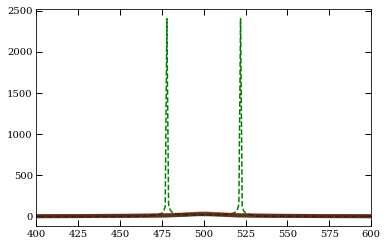

In [22]:
#plt.plot(Day, lens_vbbl.magnification(Day))
plt.plot(Day, lens_ps2.magnification(Day),'g--')
# plt.plot(Day, lens_ps2.magnification(Day),'r--')
# plt.plot(Day, lens_vbbl3.magnification(Day),'k--')

plt.plot(Day,mag1[:,510],linewidth=4,alpha=0.5, color='g')
plt.plot(Day,mag2[:,510],linewidth=4,alpha=0.5,color="r")
plt.plot(Day,mag3[:,510],linewidth=4,alpha=0.5,color="k")

plt.xlim(400,600)
# plt.ylim(1,8.2)

# plt.plot(Day,mag2[400:600,420])
# plt.plot(Day, lens_ps2.magnification(Day))
# plt.plot(Day, lens_ps2.magnification(Day) + lens_ps.magnification(Day))
#plt.plot(Data[0][15.0][0] - 52000,20*Data[0][15.0][1]+5)

/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:241: UserWarning: Convergence 0.1 is being applied!
  warnings.warn("Convergence {} is being applied!".format(K),UserWarning)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:353: RuntimeWarning: divide by zero encountered in true_divide
  component3 = self.mass_2 / np.conjugate(roots - self._position_z2)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:353: RuntimeWarning: invalid value encountered in true_divide
  component3 = self.mass_2 / np.conjugate(roots - self._position_z2)
/home/users/alpv95/.local/lib/python3.6/site-packages/MulensModel-1.14.26-py3.6-linux-x86_64.egg/MulensModel/binarylens.py:413: RuntimeWarning: divide by zero encountered in true_divide
  add_2 = self.mass_2 / (self._position_z2 - roots_ok_ba

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being a

Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!
Shear 0.0 is being applied!


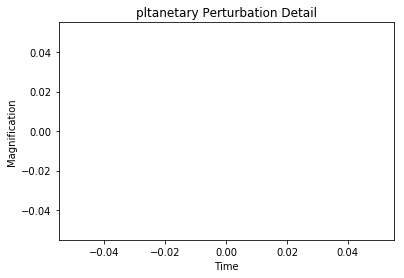

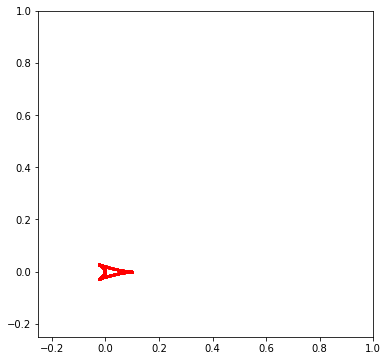

In [8]:
Day = np.arange(2000,4500,9.9)
t_0 = 3592.
u_0 = -0.32
t_E = 1200
K = 0.1
G = 0.0
s = 0.8
q = 0.01
alpha = 270.0
rho = 0.0
lens = create_lens(Day, t_0,u_0,t_E,s,q,alpha,rho, K, G)

plt.figure()
lens.plot_magnification(
    t_range=[1400., 5850.], color='red', linestyle='-', zorder=2, label='pltanet')
plt.title('pltanetary Perturbation Detail')

# pltot source trajectory and caustic
plt.figure(figsize=(6, 6))
lens.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.xlim(-0.25, 1.0)
plt.ylim(-0.25, 1.0)
#plt.title('Source Trajectory')

plt.show()

In [8]:
lens.magnification(Day)

array([1.21893456, 1.22205533, 1.22522906, 1.22845685, 1.23173987,
       1.23507931, 1.23847637, 1.24193231, 1.2454484 , 1.24902595,
       1.25266632, 1.25637088, 1.26014105, 1.2639783 , 1.26788411,
       1.27186002, 1.2759076 , 1.28002848, 1.28422432, 1.28849683,
       1.29284775, 1.29727889, 1.30179211, 1.3063893 , 1.31107242,
       1.31584349, 1.32070456, 1.32565776, 1.33070527, 1.33584935,
       1.34109229, 1.34643647, 1.35188434, 1.35743842, 1.36310127,
       1.36887558, 1.37476407, 1.38076956, 1.38689496, 1.39314325,
       1.39951751, 1.4060209 , 1.41265668, 1.41942822, 1.42633897,
       1.4333925 , 1.44059248, 1.44794268, 1.45544701, 1.46310949,
       1.47093425, 1.47892556, 1.48708781, 1.49542555, 1.50394344,
       1.5126463 , 1.5215391 , 1.53062695, 1.53991514, 1.5494091 ,
       1.55911444, 1.56903696, 1.5791826 , 1.58955752, 1.60016805,
       1.61102072, 1.62212225, 1.63347958, 1.64509984, 1.6569904 ,
       1.66915881, 1.68161288, 1.69436063, 1.7074103 , 1.72077

In [69]:
from copy import deepcopy

In [72]:
Y = pd.read_csv("/home/users/alpv95/khome/SAVRot/data/PKS1413_135_all.dat",delimiter=",")

In [73]:
Columns = Y.columns
Obs = set(Y['# Observatory'])
freqs = set(Y[' Frequency (GHz)'])
print(Columns)
print(Obs)
print(freqs)

Index(['# Observatory', ' Frequency (GHz)', ' MJD', ' Flux (Jy)',
       ' Fluxerr (Jy)'],
      dtype='object')
{'OVRO (preliminary)', 'AMI-LA', 'AMI-SA', 'Metsähovi', 'UMRAO', 'OVRO', 'Kurp', 'SMA', 'Iram4', 'Iram3', 'Sest'}
{4.8, 37.0, 230.0, 8.0, 14.5, 15.0, 22.0, 345.0, 90.0}


In [17]:
MIN_DAY1 = 48835 
MAX_DAY1 = 49600
MIN_DAY2 = 50800 
MAX_DAY2 = 52070
#48835 49850 --day2 50800 52070
Data2 = []
lower = {}
freqs = [14.5,22.0,37.0]
dt = True
datafile = "chains2_salkdjaldkjaldkasd"

DAYS = [(MIN_DAY1, MAX_DAY1),(MIN_DAY2, MAX_DAY2)]#,(MIN_DAY2, MAX_DAY2)]
lower = {}
if dt:
    if (np.array((MIN_DAY2, MAX_DAY2)) == 0).any():
        if "chains2_" in datafile:
            (MIN_DAY, MAX_DAY) = (48835,52070)
        else:
            (MIN_DAY, MAX_DAY) = (MIN_DAY1, MAX_DAY1)
    else:
        MIN_DAY = np.min(DAYS)
        MAX_DAY = np.max(DAYS)
    Flux_detrend = {}
    for freq in freqs:
        Flux = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' Flux (Jy)']
        Day = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' MJD']
        Flux_detrend[freq] = (Day.to_numpy(), detrend(Flux.to_numpy(),bp=[np.argmin(abs(Day.to_numpy() - MIN_DAY)),
                            np.argmin(abs(Day.to_numpy() - MAX_DAY))]))
        lower[freq] = Flux_detrend[freq][1][np.argmax(Flux.to_numpy())] - np.max(Flux.to_numpy())   

Data = []
for (MIN_DAY, MAX_DAY) in DAYS:
    data_dict = {}
    for freq in freqs:
        Day = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' MJD']
        Flux = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' Flux (Jy)']
        Flux_err = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][
            ' Fluxerr (Jy)']
        if dt and Day.to_numpy().size > 0: 
            flux_detrend = Flux_detrend[freq][1][(np.min(Day) <= Flux_detrend[freq][0]) * 
                                                (np.max(Day) >= Flux_detrend[freq][0])]
            data_dict[freq] = (Day.to_numpy(), flux_detrend + abs(lower[freq]), Flux_err.to_numpy())
            print(flux_detrend + abs(lower[freq]))
        else:
            data_dict[freq] = (Day.to_numpy(), Flux.to_numpy() + 0.05, Flux_err.to_numpy())
            lower[freq] = -0.05
    Data.append(data_dict)

[1.36148983 1.34858322 1.44567661 1.50277001 1.4598634  1.42695679
 1.97405018 2.15114358 2.32823697 2.17533036 2.19242376 2.02951715
 2.09661054 1.72370393 1.66079733 0.94789072 0.90498411 0.8320775
 0.8091709  0.55626429 0.54335768 0.49045108 0.55754447 0.49463786
 0.54173125 0.47882465 0.48591804 0.44301143 0.52010482 0.57719822
 0.38429161 0.441385   0.5484784  0.48557179 0.52266518 0.50975857
 0.96685197 1.01394536 0.98103875 1.08813215 1.07522554 1.20231893
 1.19941232 1.39650572 1.46359911 1.4606925  1.46778589 1.43487929
 1.63197268 1.68906607 1.47615947 1.56325286 2.15034625 2.28743964
 2.11453304 2.14162643 2.40871982 2.22581321 2.18290661 2.41
 2.11709339 2.14418679]
[2.34827756 2.3561912  2.62410483 2.46201847 2.0799321  1.83784573
 1.88575937 1.723673   1.63158664 0.85950027 0.9374139  0.77532754
 0.92324117 0.72115481 0.55906844 0.65698207 0.63489571 0.66280934
 0.58072298 0.80863661 0.68655024 0.74446388 0.67237751 0.66029114
 0.88820478 1.09611841 0.75403205 0.92194568 

0.6752456426853128
0.6752456426853128
0.6752456426853128


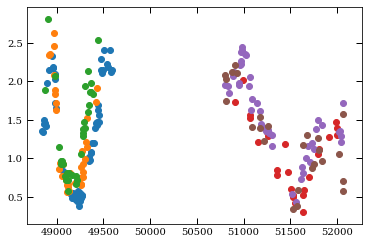

In [18]:
# plt.scatter(Data[0][freqs[0]][0],Data[0][freqs[0]][1] + abs(lower[freqs[0]]))
# plt.scatter(Data[0][freqs[1]][0],Data[0][freqs[1]][1] + abs(lower[freqs[1]]))

# plt.scatter(Data[1][freqs[0]][0],Data[1][freqs[0]][1] + abs(lower[freqs[0]]))
# plt.scatter(Data[1][freqs[1]][0],Data[1][freqs[1]][1] + abs(lower[freqs[1]]))

plt.scatter(Data[0][freqs[0]][0],Data[0][freqs[0]][1] )
plt.scatter(Data[0][freqs[1]][0],Data[0][freqs[1]][1])
plt.scatter(Data[0][freqs[2]][0],Data[0][freqs[2]][1] )

plt.scatter(Data[1][freqs[0]][0],Data[1][freqs[0]][1] )
plt.scatter(Data[1][freqs[1]][0],Data[1][freqs[1]][1])
plt.scatter(Data[1][freqs[2]][0],Data[1][freqs[2]][1] )

print(np.mean(Data[0][freqs[0]][1]) - np.std(Data[0][freqs[0]][1]))
print(np.mean(Data[0][freqs[0]][1]) - np.std(Data[0][freqs[0]][1]))
print(np.mean(Data[0][freqs[0]][1]) - np.std(Data[0][freqs[0]][1]))
#print(np.min(Data[0][freqs[0]][1] + abs(lower)))

In [70]:
Y = pd.read_csv("/home/users/alpv95/khome/SAVRot/data/PKS1413_135_all.dat",delimiter=",")

Columns = Y.columns
Obs = set(Y['# Observatory'])
freqs = set(Y[' Frequency (GHz)'])
print(Columns)
print(Obs)
print(freqs)

Days = []
Fluxes = []
Flux_errs = []
titles = []

for obs in list(Obs):
    for freq in list(freqs):
        Day = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' MJD']
        Flux = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Flux (Jy)']
        Flux_err = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Fluxerr (Jy)']
        
        if not Day.empty:
            Days.append(Day)
            Fluxes.append(Flux)
            Flux_errs.append(Flux_err)
            titles.append((obs,freq))
print(titles)

Index(['# Observatory', ' Frequency (GHz)', ' MJD', ' Flux (Jy)',
       ' Fluxerr (Jy)'],
      dtype='object')
{'Iram4', 'AMI-SA', 'Sest', 'SMA', 'OVRO (preliminary)', 'Iram3', 'UMRAO', 'Metsähovi', 'OVRO', 'Kurp', 'AMI-LA'}
{4.8, 37.0, 230.0, 8.0, 14.5, 15.0, 22.0, 345.0, 90.0}
[('Iram4', 90.0), ('AMI-SA', 15.0), ('Sest', 90.0), ('SMA', 230.0), ('SMA', 345.0), ('OVRO (preliminary)', 15.0), ('Iram3', 90.0), ('UMRAO', 4.8), ('UMRAO', 8.0), ('UMRAO', 14.5), ('Metsähovi', 37.0), ('Metsähovi', 22.0), ('OVRO', 15.0), ('Kurp', 90.0), ('AMI-LA', 15.0)]


In [71]:
titles.remove(('AMI-SA', 15.0))

In [72]:
titles.remove(('AMI-LA', 15.0))

In [11]:
titles

[('Iram4', 90.0),
 ('Iram3', 90.0),
 ('Metsähovi', 37.0),
 ('Metsähovi', 22.0),
 ('AMI-SA', 15.0),
 ('Kurp', 90.0),
 ('OVRO (preliminary)', 15.0),
 ('Sest', 90.0),
 ('SMA', 230.0),
 ('SMA', 345.0),
 ('AMI-LA', 15.0),
 ('UMRAO', 4.8),
 ('UMRAO', 8.0),
 ('UMRAO', 14.5),
 ('OVRO', 15.0)]

In [73]:
offsets = {"UMRAO 4.8": 0,"UMRAO 8.0": 1.5,"UMRAO 14.5": 3,"OVRO 15.0": 4.5, 
           "OVRO (preliminary) 15.0": 4.5, "AMI-LA 15.0": 4.5, "AMI-SA 15.0": 4.5,
          "Metsähovi 22.0": 4.5, "Metsähovi 37.0": 6.0, "SMA 230.0": 7.5, "SMA 345.0": 7.5, 
           "Kurp 90.0": 7, "Iram3 90.0": 7, "Iram4 90.0": 7, "Sest 90.0": 7}
colors = {"UMRAO 4.8": 'b',"UMRAO 8.0": 'g',"UMRAO 14.5": 'r',"OVRO 15.0": 'k', 
           "OVRO (preliminary) 15.0": 'k', "AMI-LA 15.0": "k", "AMI-SA 15.0": "k",
          "Metsähovi 22.0": 'c', "Metsähovi 37.0": 'm', "SMA 230.0": 'y', "SMA 345.0": 'orange', 
           "Kurp 90.0": 'pink', "Iram3 90.0": 'pink', "Iram4 90.0": 'pink', "Sest 90.0": 'pink'}

(0, 1.5)

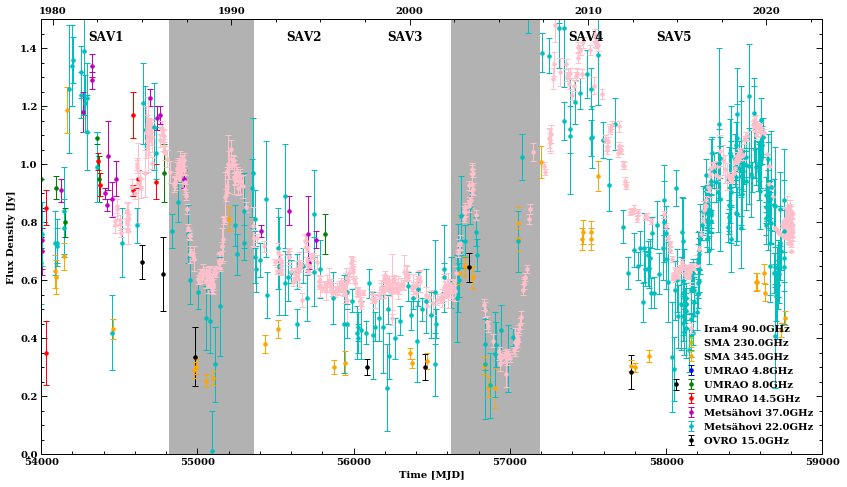

In [79]:
name_plot = "allSAVs"

MIN_DAY0 = 44860
MAX_DAY0 = 45750
MIN_DAY1 = 48835
MAX_DAY1 = 49850
MIN_DAY2 = 50800
MAX_DAY2 = 52120
# MIN_DAY3 = 57950
# MAX_DAY3 = 58330
MIN_DAY4 = 54820
MAX_DAY4 = 55360
MIN_DAY5 = 56620
MAX_DAY5 = 57190

fig, ax = plt.subplots(figsize=(14,8))

for i, title in enumerate(titles):
#+ offsets[title[0]+" "+str(title[1])]
    if title[0] in ['OVRO (preliminary)', 'AMI-LA', 'AMI-SA', 'Kurp', 'Sest', 'Iram3']:
        lab = '_nolegend_'
    else:
        lab = "{} {}GHz".format(title[0],title[1])
    plt.errorbar(Days[i],Fluxes[i],yerr=Flux_errs[i],
                 fmt='o', label=lab, color=colors[title[0]+" "+str(title[1])],markersize=3.5)
#     print(np.min(Fluxes[i]),np.max(Fluxes[i]),"{} {}".format(title[0],title[1]))
#     plt.title("Obs = {}, freq = {}".format(title[0],title[1]))
leg = ax.legend(loc=4)
ax2 = ax.twiny()
# ax.plot([MIN_DAY0,MIN_DAY0],[0,12],'k--')
# ax.plot([MAX_DAY0,MAX_DAY0],[0,12],'k--')
ax.fill_betweenx([0,12] ,MIN_DAY0, MAX_DAY0,alpha=0.3)

ax.fill_betweenx([0,12] ,MIN_DAY1, MAX_DAY1,alpha=0.3)

ax.fill_betweenx([0,12] ,MIN_DAY2, MAX_DAY2,alpha=0.3)

# ax.fill_betweenx([0,12] ,MIN_DAY3, MAX_DAY3,alpha=0.3)

ax.fill_betweenx([0,12] ,MIN_DAY4, MAX_DAY4,alpha=0.3)
ax.fill_betweenx([0,12] ,MIN_DAY5, MAX_DAY5,alpha=0.3)
ax.set_ylim(0.1,12)
ax.set_xlim(44000,60000)
ax.set_xlabel("Time [MJD]", fontweight="bold")
ax.set_ylabel("Flux Density [Jy]", fontweight="bold")
ax.annotate("SAV1", xy=(0.06, 0.95), xycoords='axes fraction', fontsize=12)
ax.annotate("SAV2", xy=(0.314, 0.95), xycoords='axes fraction', fontsize=12)
ax.annotate("SAV3", xy=(0.443, 0.95), xycoords='axes fraction', fontsize=12)
ax.annotate("SAV4", xy=(0.675, 0.95), xycoords='axes fraction', fontsize=12)
ax.annotate("SAV5", xy=(0.787, 0.95), xycoords='axes fraction', fontsize=12)

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([44239, 47892, 51544, 55197, 58849])
ax2.set_xticklabels([1980,1990,2000,2010,2020])
# ax2.set_xlabel(r"Date")

# plt.savefig("plots/" + name_plot + ".pdf",format="pdf")
# plt.plot([MIN_DAY4,MIN_DAY4],[0,12],'k--')
# plt.plot([MAX_DAY4,MAX_DAY4],[0,12],'k--')

ax.set_xlim(54000,59000)
ax.set_ylim(0,1.5)


First try fitting SAV2 across all relevant bands:
- UMRAO 4.8
- UMRAO 8.0
- UMRAO 14.5
- Metsahovi 22
- Metsahovi 37
- Sest 90, Iram3 90, Iram4 90, Kurp 90


In [2]:
!ls ..

current_11476253_4294967294.out		tony2_theta_6freq_logtoff
current_11476685_4294967294.out		tony2_theta_6freq_logtoff_wide
current_11504593_4294967294.out		tony2_theta_6freq_paper
current_11515452_4294967294.out		tony2_theta_6freq_PAPER
current_11569915_4294967294.out		tony2_theta_6freq_paper2
current_11569917_4294967294.out		tony2_theta_6freq_PAPERiric
current_11569936_4294967294.out		tony3_alphagauss
current_13914880_4294967294.out		tony3_alphagauss2
current_13919246_4294967294.out		tony3_kipac
data					tony3_kipac_gauss
debug					tony3_kipac_gauss2
direct.py				tony3_kipac_somealpha2
J1415+1320.csv				tony3_theta_5freq
lens_fit2.py				tony3_theta_5freq_logtoff
lens_fit.py				tony3_theta_5freq_logtoff_wide
LS_cyl_PA				tony3_theta_5freq_PAPER
model_weightsBLSTM_64			tony3_theta_5freq_PAPERkip
nest.sh					tony3_theta_6freq_paper2
notebooks				tony45_alphafull
polynomial.py				tony45_alphafull2
README.md				tony45_alphafullfull
report.log				tony45_alphafullfull2
rot_fit.py				tony45_a

In [ ]:
#"tony45_alpharestrict""tony45_jointsep2""tony45_alphafullfull"
#"tony1_alphagauss""tony1_kipac"
#"tony2_alphagauss2""tony2_kipac"
#"tony3_alphagauss2"

In [2]:
name = "tony2_alphagauss2"
with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
# print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)
print("L: {} \n".format(a.get_best_fit()['log_likelihood']))
try:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n t0_off: {} \n".format(*a.get_best_fit()["parameters"][:10]))
except IndexError:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n".format(*a.get_best_fit()["parameters"][:10]))
result = a.get_best_fit()['parameters']
print(result)


  analysing data from /home/users/alpv95/khome/SAVRot/tony2_alphagauss2/3-_1_.txt
L: -1602.7356820489072 

 t_0: 49244.94937202209 
 u_0: -0.008528063086343574 
 t_E: 4671.91925805708 
 s: 1.1965673892213973 
 q: 0.009505458603444605 
 alpha: 247.48589597323888 
 k: 0.07853347653401013 
 gamma: 0.03449823307799043 
 theta: 3.949754502262871 
 t0_off: -0.0010086828509563925 

[49244.94937202209, -0.008528063086343574, 4671.91925805708, 1.1965673892213973, 0.009505458603444605, 247.48589597323888, 0.07853347653401013, 0.03449823307799043, 3.949754502262871, -0.0010086828509563925, -0.18828084201878714]


In [3]:
name = "tony2_kipac"
with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
# print(n_params)
a2 = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)
print("L: {} \n".format(a2.get_best_fit()['log_likelihood']))
try:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n t0_off: {} \n".format(*a2.get_best_fit()["parameters"][:10]))
except IndexError:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n".format(*a2.get_best_fit()["parameters"][:10]))
result = a2.get_best_fit()['parameters']
print(result)

  analysing data from /home/users/alpv95/khome/SAVRot/tony2_kipac/3-_1_.txt
L: -1012.9756553598944 

 t_0: 49135.223670431056 
 u_0: 0.08920012643461706 
 t_E: 3834.1192946702063 
 s: 0.843450486830112 
 q: 0.0061521786026073515 
 alpha: 109.16850897514813 
 k: 0.013244186858587585 
 gamma: 0.04522323905821015 
 theta: 2.1781780203103462 
 t0_off: -0.000707486465271797 

[49135.223670431056, 0.08920012643461706, 3834.1192946702063, 0.843450486830112, 0.0061521786026073515, 109.16850897514813, 0.013244186858587585, 0.04522323905821015, 2.1781780203103462, -0.000707486465271797, -0.15803758294557607]


In [6]:
name = "tony45_alphafullfull"
with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
# print(n_params)
a3 = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)
print("L: {} \n".format(a3.get_best_fit()['log_likelihood']))
try:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n t0_off: {} \n".format(*a3.get_best_fit()["parameters"][:10]))
except IndexError:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n".format(*a3.get_best_fit()["parameters"][:10]))
result = a3.get_best_fit()['parameters']
print(result)

  analysing data from /home/users/alpv95/khome/SAVRot/tony45_alphafullfull/3-_1_.txt
L: -1161.0201849760467 

 t_0: 55059.86275559897 
 u_0: -0.0925318575099019 
 t_E: 3518.0344392625175 
 s: 1.1697858374353298 
 q: 0.0097830542383658 
 alpha: 269.47368163519593 
 k: 0.0010974084700367374 
 gamma: 0.031069190815736156 
 theta: 0.2279512076911584 
 t0_off: -0.00021848305042015265 

[55059.86275559897, -0.0925318575099019, 3518.0344392625175, 1.1697858374353298, 0.0097830542383658, 269.47368163519593, 0.0010974084700367374, 0.031069190815736156, 0.2279512076911584, -0.00021848305042015265, -0.07412567171241533, 56895.56028347491, -0.0825114299623847, 4499.230216652003, 261.994566140446]


In [26]:
name = "tony45_separate2"
with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
# print(n_params)
a4 = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)
print("L: {} \n".format(a4.get_best_fit()['log_likelihood']))
try:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n t0_off: {} \n".format(*a4.get_best_fit()["parameters"][:10]))
except IndexError:
    print(" t_0: {} \n u_0: {} \n t_E: {} \n s: {} \n q: {} \n alpha: {} \n k: {} \n gamma: {} \n theta: {} \n".format(*a4.get_best_fit()["parameters"][:10]))
result = a4.get_best_fit()['parameters']
print(result)

  analysing data from /home/users/alpv95/khome/SAVRot/tony45_separate2/3-_1_.txt
L: -329.62020389584893 

 t_0: 55016.125905651024 
 u_0: -0.051319073375825974 
 t_E: 3213.3318841577816 
 s: 1.0935640604235797 
 q: 0.005310906292155938 
 alpha: 250.5539760088164 
 k: 0.13733366251231 
 gamma: 0.0996559430815061 
 theta: 0.5178433616342057 
 t0_off: -0.0002392164139907102 

[55016.125905651024, -0.051319073375825974, 3213.3318841577816, 1.0935640604235797, 0.005310906292155938, 250.5539760088164, 0.13733366251231, 0.0996559430815061, 0.5178433616342057, -0.0002392164139907102, -0.05694638948407932, 56912.1250838035, -0.03558390704957182, 4233.640018299012, 247.48845787262007]


In [47]:
print(a.get_mode_stats()["modes"][0]["mean"][2])
print(a.get_mode_stats()["modes"][0]["sigma"][2])
print(a.get_mode_stats()["modes"][0]["maximum a posterior"][2])

3009.5579215506673
31.36246966921871
3037.3459588797023


In [42]:
def BIC(logl, N, n_params):
    return n_params * np.log(N) - 2*logl

def AIC(logl, n_params):
    return 2*n_params - 2*logl

def BIC_ev(logl, N, n_params):
    return  logl - n_params/2 * np.log(N)

def model_post(idx, bic_list, const):
    bic_list = np.array(bic_list) * const
    return np.exp(-0.5*bic_list[idx]) / np.sum(np.exp(-0.5*bic_list))

In [43]:
print([BIC(-1188.13, 296+90, 11), BIC(-1193.7, 296+90, 12), BIC(-1715.096350462033, 296+90, 11),BIC(-2012, 296+90, 10)])
print([BIC_ev(-1188.13, 296+90, 11), BIC_ev(-1193.7, 296+90, 12),BIC_ev(-1715.0906, 296+90, 11), BIC_ev(-2012, 296+90, 10)])
print([AIC(-1188.13, 11), AIC(-1193.7, 12),AIC(-1715.0906, 11), AIC(-2012, 10)])

[2441.7742110641134, 2458.870048433578, 3495.706911988179, 4083.5583736946483]
[-1220.8871055320567, -1229.435024216789, -1747.8477055320566, -2041.7791868473241]
[2398.26, 2411.4, 3452.1812, 4044]


In [21]:
parameters_plot = ['t_0',
 'u_0',
 't_E',
 's',
 'q',
 '\\alpha',
 'K',
 'G',
 '\\theta',
 '\\beta_0',
 '\\beta_E',
 't_{02}',
 'u_{02}',
 't_{E2}',
 '\\alpha_2']


#names = ["tony1_kipac_gauss2","tony2_kipac","tony2_kipac_gauss2","tony3_kipac_gauss2","tony45_kipac_fullsplit3","tony45_kipac_fullsplit3"]
names = ["tony1_alphagauss2", "tony2_alphagauss2","tony3_alphagauss2","tony45_alpharestrict","tony45_alpharestrict"]
for k, name in enumerate(names):
    with open('/home/users/alpv95/khome/SAVRot/'+ name + '/3-_1_params.json') as json_file:
        parameters = json.load(json_file)
    n_params = len(parameters)
    a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/" + name + "/3-" + '_1_', n_params = n_params)

    name_plot = "45_corner"
    active = [i for i in range(11)] #[3,4,6,7,8]
    ndim = len(active)

    CI = np.zeros((len(active),2))
    for j,i in enumerate(active):
        lower = np.quantile(a.get_equal_weighted_posterior()[:,i],0.0015)
        upper = np.quantile(a.get_equal_weighted_posterior()[:,i],0.9985)
        CI[j,0] = lower
        CI[j,1] = upper

    to_write = []
    to_write.append("SAV{}".format(name[4]))
    for i,j in enumerate(active):
        name = parameters_plot[j]
        to_write.append(r"${:.6}^{{+{:.4}}}_{{-{:.4}}}$".format(np.median(a.get_equal_weighted_posterior()[:,j]),
                                                          abs(CI[i,1]-np.median(a.get_equal_weighted_posterior()[:,j])), 
                                                          abs(CI[i,0] -np.median(a.get_equal_weighted_posterior()[:,j]))) )    
        
    with open('paper_table2.csv', mode='a') as file:
        writer = csv.writer(file, delimiter='&', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(to_write)
    

  analysing data from /home/users/alpv95/khome/SAVRot/tony1_alphagauss2/3-_1_.txt
  analysing data from /home/users/alpv95/khome/SAVRot/tony2_alphagauss2/3-_1_.txt
  analysing data from /home/users/alpv95/khome/SAVRot/tony3_alphagauss2/3-_1_.txt
  analysing data from /home/users/alpv95/khome/SAVRot/tony45_alpharestrict/3-_1_.txt
  analysing data from /home/users/alpv95/khome/SAVRot/tony45_alpharestrict/3-_1_.txt


In [4]:
def binary_search(dist, centre, ci=0.67, eps=1e-3):
    '''
    Find confidence intervals in 1D posterior histogram
    '''
    N = len(dist)
    bounds = [centre,centre]
    n = 0
    while n <= ci*N:
        upper = np.sum((dist <= bounds[1] + eps) * (dist >= bounds[1]))
        lower = np.sum((dist >= bounds[0] - eps) * (dist <= bounds[0]))
        if upper > lower or bounds[0] <= 0:
            bounds[1] += eps
        else:
            bounds[0] -= eps
        n = np.sum((dist >= bounds[0])*(dist <= bounds[1]))    
    return bounds

/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


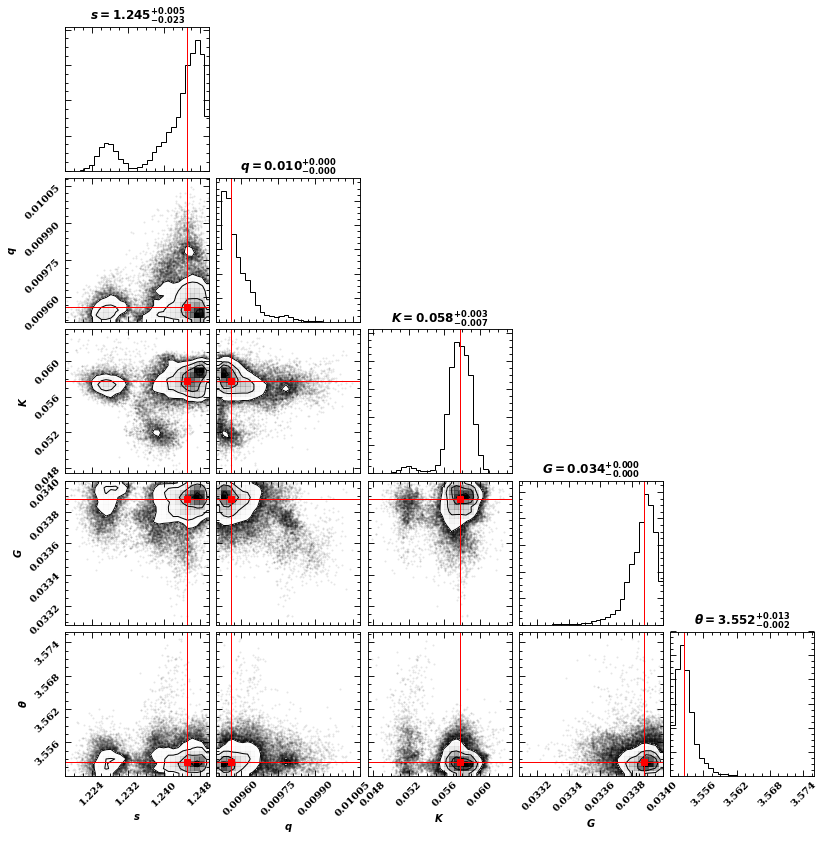

In [9]:
parameters_plot = ['t_0',
 'u_0',
 't_E',
 's',
 'q',
 '\\alpha',
 'K',
 'G',
 '\\theta',
 't_0^{off}',
 't_E^{off}',
 't_{02}',
 'u_{02}',
 't_{E2}',
 '\\alpha_2']

name_plot = "45_corner"
active = [3,4,6,7,8] #[i for i in range(len(a.get_best_fit()['parameters']))] #[3,4,6,7,8]
ndim = len(active)

fig = corner.corner(a.get_equal_weighted_posterior()[:,active],
                    title_fmt=".3f", bins=30,)

CI = np.zeros((len(active),2))
for j,i in enumerate(active):
    lower = np.quantile(a.get_equal_weighted_posterior()[:,i],0.0015)
    upper = np.quantile(a.get_equal_weighted_posterior()[:,i],0.9985)
    CI[j,0] = lower
    CI[j,1] = upper

value1 = [a.get_mode_stats()["modes"][0]["maximum a posterior"][i] for i in active]
value2 = np.median(a.get_equal_weighted_posterior()[:,active],axis=0)

axes = np.array(fig.axes).reshape((ndim, ndim))
for i,j in enumerate(active):
    ax = axes[i, i]
#     ax.axvline(value1[i], color="g")
    ax.axvline(value2[i], color="r")
    name = parameters_plot[j]
    ax.set_title(r"${} = {:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$".format(name,
                                                      np.median(a.get_equal_weighted_posterior()[:,j]),
                                                      abs(CI[i,1]-np.median(a.get_equal_weighted_posterior()[:,j])), 
                                                      abs(CI[i,0] -np.median(a.get_equal_weighted_posterior()[:,j]))))
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        if yi == (ndim-1):
            ax.set_xlabel(r"${}$".format(parameters_plot[active[xi]]),fontweight="bold")
        if xi == 0:
            ax.set_ylabel(r"${}$".format(parameters_plot[active[yi]]),fontweight="bold")
#         ax.axvline(value1[xi], color="g")
        ax.axvline(value2[xi], color="r")
#         ax.axhline(value1[yi], color="g")
        ax.axhline(value2[yi], color="r")
#         ax.plot(value1[xi], value1[yi], "sg")
        ax.plot(value2[xi], value2[yi], "sr")

# plt.savefig("plots/" + name_plot + ".pdf",format="pdf")

In [209]:
2*np.pi - 3.609

2.6741853071795862

In [206]:
data = a.get_data()[:,2:][:,4]
weights = a.get_data()[:,0]

In [207]:
weights2 = a.get_data()[:,1]

In [180]:
print(a.get_mode_stats()["modes"][0]["mean"][6])
np.mean(a.get_equal_weighted_posterior()[:,6],axis=0)

0.07763479187828903


0.07759624995656501

In [5]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def create_lens(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270, K=0.0, G=0.0, theta=0.0):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha, 'rho':0.0,'K': K, 
         'G': G*complex(np.cos(theta),np.sin(theta))})
    lens.set_magnification_methods([min(Day), 'vbbl', max(Day)])  
    
    return lens

def QPsolver(data, prediction, lower, K, G):
    _, Flux, Flux_err = data
    upper_const = np.min(Flux) + 0.25 
    upper_mult = np.max(Flux) - 0.25
#     print("UPPER", upper_const, upper_mult, np.min(Flux), Flux_err[np.argmin(Flux)])

    m = len(Flux);  #dimensions
    w = np.diag(1 / Flux_err)
    b = np.matmul(w, Flux)
    if type(prediction) is tuple:
        n = 3
        constraint_M = np.array([[((1-K)**2 - G**2)**(-1), ((1-K)**2 - G**2)**(-1), 1], [0, 0, 1], [1, 0, 0], [0, 1, 0]])
        Ad = np.matmul(w, np.concatenate([np.array([[p1, p2, 1]]) for p1, p2 in np.array(prediction).T], axis=0))
        l = np.hstack([b, 0, 1e-7, 5e-5, 5e-5])
        u = np.hstack([b, upper_const, upper_const, upper_mult, upper_mult])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n+1, m))])], format='csc')
    else:
        n=2
        constraint_M = np.array([[((1-K)**2 - G**2)**(-1), 1],[0, 1], [1, 0]])
        Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
        l = np.hstack([b, 0, 1e-7, 5e-5])
        u = np.hstack([b, upper_const, upper_const, upper_mult])
        Ad = sparse.csc_matrix(Ad)
        A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n+1, m))])], format='csc')
    
    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)


    with nostdout():
        # Create an OSQP object
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, Q, A, l, u, eps_rel=1e-4, polish=1)
        # Solve problem
        res = prob.solve()

#     print(res.info.obj_val)
    return res.x[:3], res.info.obj_val #flux_scale and loss

In [6]:
def second_smallest(numbers):
    m1, m2 = float('inf'), float('inf')
    i1, i2 = -1, -1
    for i, x in enumerate(numbers):
        if x <= m1:
            m1, m2 = x, m1
            i1, i2 = i, i1
        elif x < m2:
            m2 = x
            i2 = i
    return m2, i2

def flatten_data(x, y):
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    slope = lr.coef_[0]
    y_int = lr.intercept_
    flattened = []
    for i in range(len(x)):
        expected_val = slope * x[i] + y_int
        flattened.append(y[i] - expected_val)
    return np.array(flattened), slope, y_int

4.8 b [ 0.02059033  0.54970162 -0.17040203]
4.8 b [ 0.01994809  0.55627786 -0.33000851]
4.8 b [ 0.02008852  0.55409946 -0.27730501]
4.8 b [ 0.02031113  0.55147342 -0.2554635 ]
4.8 b [ 0.02011094  0.55211538 -0.22508438]
4.8 b [ 0.01994762  0.55421008 -0.26457861]
4.8 b [ 0.02052488  0.54962854 -0.15814857]
4.8 b [ 0.02027524  0.55209516 -0.27047852]
4.8 b [ 0.02052485  0.54998343 -0.25386486]
4.8 b [ 0.02037347  0.55141119 -0.18362361]
4.8 b [ 0.02039859  0.55124268 -0.21039791]
4.8 b [ 0.02066149  0.54911226 -0.15885691]
4.8 b [ 0.02040516  0.55137198 -0.19120713]
4.8 b [ 0.02038875  0.55132879 -0.19518946]
4.8 b [ 0.02116048  0.54669993 -0.04402659]
4.8 b [ 0.02023431  0.55187368 -0.21117925]
4.8 b [ 0.02022553  0.55245992 -0.18562868]
4.8 r [ 0.02397926  0.56315217 -0.49334178]
4.8 r [ 0.02330168  0.56521897 -0.46027187]
4.8 r [ 0.02720837  0.56269889 -0.60156944]
4.8 r [ 0.02404579  0.56378697 -0.52303684]
4.8 r [ 0.02443347  0.56241308 -0.53884238]
4.8 r [ 0.02395339  0.56277035 -

90.0 b [ 7.02497801e-02  9.99999997e-08 -2.20111063e+00]
90.0 b [ 6.98540605e-02  9.99999997e-08 -2.19565170e+00]
90.0 b [ 6.91456283e-02  9.99999997e-08 -2.22154891e+00]
90.0 b [ 6.95501420e-02  9.99999997e-08 -2.21611731e+00]
90.0 b [ 6.92432667e-02  9.99999997e-08 -2.16655045e+00]
90.0 b [ 6.96241872e-02  9.99999997e-08 -2.24790031e+00]
90.0 b [ 6.94714552e-02  9.99999997e-08 -2.09563613e+00]
90.0 b [ 6.87983722e-02  9.99999997e-08 -2.07747887e+00]
90.0 r [ 9.12297191e-02  9.99999999e-08 -1.90275687e+00]
90.0 r [ 9.08092721e-02  9.99999999e-08 -1.77029332e+00]
90.0 r [ 1.03189215e-01  9.99999999e-08 -1.93226606e+00]
90.0 r [ 8.98492471e-02  9.99999999e-08 -1.65507329e+00]
90.0 r [ 9.22091793e-02  9.99999999e-08 -1.84099381e+00]
90.0 r [ 9.09029504e-02  9.99999999e-08 -1.85163853e+00]
90.0 r [ 9.48887399e-02  9.99999999e-08 -1.77057446e+00]
90.0 r [ 9.35069221e-02  9.99999999e-08 -1.81742249e+00]
90.0 r [ 9.20945705e-02  9.99999999e-08 -1.86886636e+00]
90.0 r [ 9.13608377e-02  9.9999

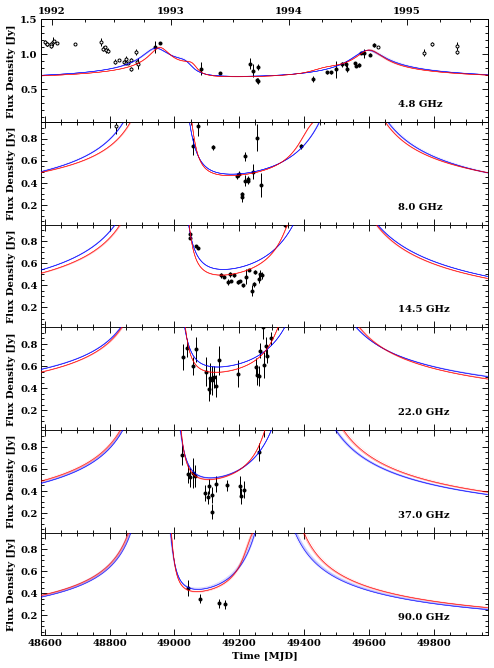

In [7]:
name_plot = "2_flux_zoom"
# MIN_DAY1 = 50800  #50800  #48835
# MAX_DAY1 = 52070  #52070 #49625
# MIN_DAY2 = 0  #54870#50800
# MAX_DAY2 = 0  #57190#52070
#48835 52070
#54870 57190
#49850 50800
#44775 45650

savs = [2, 6, 6]
SAVS = [sav-1 for sav in savs]
freqs = [4.8, 8.0, 14.5,22.0,37.0, 90.0,] #[4.8,8.0,14.5,15.0,22.0,37.0,90.0,230.0]
freqs_idx = [[4.8, 8.0, 14.5, 15.0, 22.0, 37.0, 90.0, 230.0].index(freq) for freq in freqs]
DAYS = np.array([[(44775, 45700),(44775, 45750),(44775, 45750),(0,0),(0,0),(0,0),(0,0),(0,0)],
                 #[(44840, 45250),(44840, 45250),(44840, 45250),(0,0),(0,0),(0,0),(0,0),(0,0)],
                 [(48935,49625),(48935,49580),(48935,49520),(0,0),(48935,49520),(48935,49520),(48900,49250),(0,0)],
                 [(50800,52070),(50800,52070),(50800,52070),(0,0),(50950,51900),(50900,51780),(0,0),(0,0)],
                 [(0,0),(0,0),(0,0),(54870, 55400),(0,0),(54820, 55350),(0,0),(54820,55350)],
                 [(0,0),(0,0),(0,0),(56620, 57190),(0,0),(56600, 57100),(0,0),(56620,57190)],
#                  [(0,0),(0,0),(0,0),(54870, 57190),(0,0),(54820, 57100),(0,0),(54820,57190)],
#                  [(0,0),(0,0),(0,0),(54870, 57190),(0,0),(54820, 57100),(0,0),(54820,57190)],
                 [(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]])

join = False
dt = False
outer = 350


Y = pd.read_csv("/home/users/alpv95/khome/SAVRot/data/PKS1413_135_all.dat", delimiter=",")
offsets = {4.8: 0, 8.0: 1.5, 14.5: 3, 15.0: 4.5,
          22.0: 4.5, 37.0: 6.0, 230.0: 7.5, 345.0: 7.5,
           90.0: 7,}
if join:
    for i in range(len(Y)):
        if Y.loc[i,' Frequency (GHz)'] == freqs[1]:
            Y.loc[i,' Frequency (GHz)'] = freqs[0]
    freqs = [freqs[0]]

Data1 = {}
Data2 = {}
Data3 = {}
Data_plot = {}
lower = {}
slope = {}
y_int = {}

if dt:
    Flux_detrend = {}
    for f,freq in enumerate(freqs):
        MIN_DAY, _ = DAYS[3,freqs_idx[f]]
        _, MAX_DAY = DAYS[4,freqs_idx[f]]
        Flux = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' Flux (Jy)']
        Day = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' MJD']
        if f < 2:
#             Flux_detrend[freq] = (Day.to_numpy(), detrend(Flux.to_numpy(),bp=[np.argmin(abs(Day.to_numpy() - MIN_DAY)),
#                                 np.argmin(abs(Day.to_numpy() - MAX_DAY))+1]))
            FLUX, slope[freq], y_int[freq] = flatten_data(Day.to_numpy(), Flux.to_numpy())
            Flux_detrend[freq] = (Day.to_numpy(), FLUX)
        else:
            Flux_detrend[freq] = (Day.to_numpy(), detrend(Flux.to_numpy(),bp=[np.argmin(abs(Day.to_numpy() - MIN_DAY)),
                                np.argmin(abs(Day.to_numpy() - MAX_DAY))+1],type="constant"))
            slope[freq] = 0
            y_int[freq] = np.mean(Flux.to_numpy())
        lower[freq] = Flux_detrend[freq][1][second_smallest(Flux.to_numpy())[1]] - second_smallest(Flux.to_numpy())[0]   

Data = []
Data_extra = []
for sav in SAVS:
    data_dict = {}
    data_dict_extra = {}
    for f, freq in enumerate(freqs):
        MIN_DAY, MAX_DAY = DAYS[sav,freqs_idx[f]]
        Day = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' MJD']
        Flux = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][' Flux (Jy)']
        Flux_err = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY) & (Y[' MJD'] > MIN_DAY)][
            ' Fluxerr (Jy)']
        
        Day_extra = Y.loc[(Y[' Frequency (GHz)'] == freq) & (((Y[' MJD'] > MAX_DAY) & (Y[' MJD'] < MAX_DAY + outer)) 
                          | ((Y[' MJD'] > MIN_DAY -outer)  & (Y[' MJD'] < MIN_DAY)))][' MJD']
        Flux_extra = Y.loc[(Y[' Frequency (GHz)'] == freq) & (((Y[' MJD'] > MAX_DAY) & (Y[' MJD'] < MAX_DAY + outer)) 
                          | ((Y[' MJD'] > MIN_DAY -outer)  & (Y[' MJD'] < MIN_DAY)))][' Flux (Jy)']
        Flux_err_extra = Y.loc[(Y[' Frequency (GHz)'] == freq) & (((Y[' MJD'] > MAX_DAY) & (Y[' MJD'] < MAX_DAY + outer)) 
                          | ((Y[' MJD'] > MIN_DAY -outer)  & (Y[' MJD'] < MIN_DAY)))][
            ' Fluxerr (Jy)']
        
        if dt and Day.to_numpy().size > 0: 
            flux_detrend = Flux_detrend[freq][1][(np.min(Day) <= Flux_detrend[freq][0]) * 
                                                (np.max(Day) >= Flux_detrend[freq][0])]
            data_dict[freq] = (Day.to_numpy(), flux_detrend + abs(lower[freq]) + 0.05, Flux_err.to_numpy())
            data_dict_extra[freq] = (Day_extra.to_numpy(), Flux_extra.to_numpy() + 0.05 
                                     - slope[freq]*Day_extra.to_numpy() - y_int[freq] + abs(lower[freq]), 
                                     Flux_err_extra.to_numpy())
        else:
            data_dict[freq] = (Day.to_numpy(), Flux.to_numpy() + 0.05, Flux_err.to_numpy())
            data_dict_extra[freq] = (Day_extra.to_numpy(), Flux_extra.to_numpy() + 0.05, 
                                     Flux_err_extra.to_numpy())
            lower[freq] = -0.05
            
    Data.append(data_dict)
    Data_extra.append(data_dict_extra)
Data1 = Data[0]
Data2 = Data[1]
Data1_extra = Data_extra[0]
Data2_extra = Data_extra[1]

fig, ax = plt.subplots(figsize=(8,11.33),nrows=len(freqs),sharex=True, gridspec_kw={"hspace":0.0})
# if not isinstance(ax, tuple):
#     ax = [ax]
    
# y_int[230.0] = 0.58
#  + Day1 * slope[freq] + y_int[freq]-0.58
for i, freq in enumerate(freqs):
    Day1, Flux1, Flux_err1 = Data1[freq]
    Day2, Flux2, Flux_err2 = Data2[freq]
    Day_extra, Flux_extra, Flux_err_extra = Data1_extra[freq]
    Day_extra2, Flux_extra2, Flux_err_extra2 = Data2_extra[freq]
    ax[i].errorbar(Day1,Flux1,yerr=Flux_err1,
                 fmt='o', label="{} GHZ".format(freq),color="k",markersize=3,capsize=0)
    ax[i].errorbar(Day_extra,Flux_extra , yerr=Flux_err_extra,
                 fmt='o', mfc='white', markersize=3,capsize=0)
    ax[i].errorbar(Day_extra2,Flux_extra2, yerr=Flux_err_extra2,
                 fmt='o', mfc='white', markersize=3,capsize=0)
    ax[i].errorbar(Day2,Flux2, yerr=Flux_err2,
                 fmt='o',color="k", markersize=3,capsize=0)
    
    if not i:
        try:
            Day = np.linspace(min(Day1)- outer, max(Day2)+ outer,1000) #for smooth full lens plot
            ax[i].set_xlim(min(Day1)- outer, max(Day2)+ outer)
        except:
            Day = np.linspace(min(Day1)-outer,max(Day1)+ outer,1000)
            ax[i].set_xlim(min(Day1)- outer,max(Day1)+ outer)
    #upper = np.mean(Data1[freq][1]) - 1*np.std(Data1[freq][1])
    G = 0.0
    K = 0.0
    toff = 0.0
    toffE = 0.0
    theta = 0.0
    #t_02, u_02, t_E2, alpha2, toff,toffE,
    for A,color in zip([a,a2],['b','r','cyan']):
        for idx, (t_0, u_0, t_E, s, q, alpha, K, G,theta, toff, toffE,) in enumerate(A.get_equal_weighted_posterior()[::3000, :-1]):
            if idx == 0:
                t_0, u_0, t_E, s, q, alpha, K, G, theta, toff, toffE, = A.get_best_fit()['parameters']
                transparency = 1
            else:
                transparency = 0.1
                                
            Day1, _, _ = Data1[freq]
            Day2, _, _ = Data2[freq]

            t_0 = freq**toff * t_0 / (freqs[0] ** toff)
            t_E = freq**toffE * t_E / (freqs[0] ** toffE)
            if Day2.size:
                t_02 = freq**toff * t_02 / (freqs[0] ** toff)
                t_E2 = freq**toffE * t_E2 / (freqs[0] ** toffE)

                if (Day1.size == Day2.size) and (Day1 == Day2).all():
                    Day_current = Day1
                    Data_current = Data1[freq]
                else:
                    Day_current = np.concatenate((Day1,Day2))
                    Data_concat = np.hstack((Data1[freq], Data2[freq]))
                    Data_current = (Data_concat[0],Data_concat[1],Data_concat[2])

                if color != 'orange':
                    lens1 = create_lens(Day_current, t_0, u_0, t_E, s, q, alpha, K, G, theta)
                    lens2 = create_lens(Day_current, t_02, u_02, t_E2, s, q, alpha2, K, G, theta)
                    p_hat1 = lens1.magnification(Day_current)
                    p_hat2 = lens2.magnification(Day_current)            
                    flux_scale1, _ = QPsolver(Data_current, (p_hat1, p_hat2), lower[freq], K, G)

                    lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha,  K,G, theta)
                    lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2, K,G, theta)
                    p_hat_plot1 = lens1.magnification(Day)
                    p_hat_plot2 = lens2.magnification(Day)

                    ax[i].plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1] * p_hat_plot2 + flux_scale1[2] 
                               + Day * slope[freq] + y_int[freq] - 0.58
                          , alpha=transparency, color=color,zorder=10,linestyle="-",linewidth=0.5)
#                 ax[i].plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[2] 
#                   , alpha=0.3, color='b',linestyle="-")
#                 ax[i].plot(Day,flux_scale1[1] * p_hat_plot2 + flux_scale1[2]
#                    , alpha=0.3, color='b',linestyle="-")
#                 print(freq, flux_scale1[2])
                else:
                    lens1 = create_lens(Day1, t_0, u_0, t_E, s, q, alpha, K, G, theta)
                    lens2 = create_lens(Day2, t_02, u_02, t_E2, s, q, alpha2, K, G, theta)
                    p_hat1 = lens1.magnification(Day1)
                    p_hat2 = lens2.magnification(Day2)            
                    flux_scale1, _ = QPsolver(Data1[freq], p_hat1, lower[freq], K, G)
                    flux_scale2, _ = QPsolver(Data2[freq], p_hat2, lower[freq], K, G)

                    lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha,  K,G, theta)
                    lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2, K,G, theta)
                    p_hat_plot1 = lens1.magnification(Day)
                    p_hat_plot2 = lens2.magnification(Day)
#                     smooth = (-np.eye(1000) + np.diag(np.ones(999), 1))[:-1,:]
#                     print("Smooth1: ", np.sum((smooth@p_hat_plot1)**2))
#                     print("Smooth2: ", np.sum((smooth@p_hat_plot2)**2))

                    ax[i].plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1] 
                      , alpha=transparency, color=color, linewidth=0.5,ls='-')
                    ax[i].plot(Day,flux_scale2[0] * p_hat_plot2 + flux_scale2[1]
                       , alpha=transparency, color=color, linewidth=0.5,ls='-')


            elif Day1.size and not Day2.size:

                lens1 = create_lens(Day1, t_0, u_0, t_E, s, q, alpha, K, G, theta)
                p_hat1 = lens1.magnification(Day1)
                flux_scale1, _ = QPsolver(Data1[freq], p_hat1, lower[freq], K, G)

                lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha, K, G, theta)
                p_hat_plot1 = lens1.magnification(Day)
                smooth = (-np.eye(1000) + np.diag(np.ones(999), 1))[:-1,:]
#                 print("Smooth: ", np.sum((smooth@p_hat_plot1)**2))

                ax[i].plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1]
                     , alpha=transparency, color=color,zorder=10, linewidth=0.5,linestyle="-")
                print(freq,color, flux_scale1)
#                 print(freq, flux_scale1[1])

    #             ax[i].errorbar(Day1,(Flux1 - flux_scale1[1])/p_hat1 + flux_scale1[1], yerr=Flux_err1,
    #                  fmt='o', label="{} GHz No Lens".format(freq),color="r")
                #ax[i].plot([min(Day),max(Day)],[lower[freq],lower[freq]])


#     leg = ax[i].legend(loc = "upper center",)
#     for line, text in zip(leg.get_lines(), leg.get_texts()):
#         text.set_color(line.get_color())
    ax[i].annotate("{} GHz".format(freq), xy=(0.8, 0.15), xycoords='axes fraction', fontsize=10)
    ax[i].set_ylim(ymin=0.05)
    
ax[0].set_ylim(ymin=0.02, ymax=1.5)
ax[1].set_ylim(ymin=0.02, ymax=0.95)
ax[2].set_ylim(ymin=0.02, ymax=0.95)
ax[3].set_ylim(ymin=0.02, ymax=0.95)
ax[4].set_ylim(ymin=0.02, ymax=0.95)
ax[5].set_ylim(ymin=0.02, ymax=0.95)
# ax[0].set_xlim(54500, 555000)
    
ax[-1].set_xlabel(r"Time [MJD]",fontweight="bold")
# ax[:].set_ylabel(r"Flux Density [Jy]",fontweight="bold")
for axi in ax:
    axi.set_ylabel(r"Flux Density [Jy]",fontweight="bold")
    
ax2 = ax[0].twiny()
ax2.set_xlim(ax[0].get_xlim())
times = [str(x) + '-01-01T00:00:00' for x in range(1980,2021,1)]
t = Time(times, format='isot', scale='utc')
ax2.set_xticks(t.mjd)
ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticklabels([str(x) for x in range(1980,2021,1)])

plt.savefig("plots/" + name_plot + ".pdf",format="pdf")

In [ ]:
+ Day1 * slope[15.0] + y_int[15.0]-0.58

In [40]:
x = flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2 + flux_scale1[2]

In [42]:
y = flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2 + flux_scale1[2]

In [53]:
z = flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2 + flux_scale1[2]

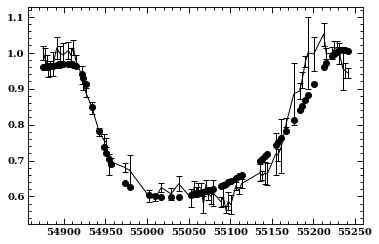

In [65]:
num = 70
plt.scatter(Day1[:num], flux_scale1[0] * p_hat1[:num] + flux_scale1[1] * p_hat2[:num] + flux_scale1[2]
            + Day1[:num] * slope[15.0] + y_int[15.0]-0.58,)
plt.errorbar(Day1[:num],Flux1[:num] + Day1[:num] * slope[15.0] + y_int[15.0]-0.58, yerr=Flux_err1[:num],)

np.savetxt("reflect_SAV4.csv", np.stack([Day1[:num],Flux1[:num] + Day1[:num] * slope[15.0] + y_int[15.0]-0.58, 
                                         Flux_err1[:num], 
                                         x[:num]+ Day1[:num] * slope[15.0] + y_int[15.0]-0.58,
                                         y[:num]+ Day1[:num] * slope[15.0] + y_int[15.0]-0.58,
                                         z[:num]+ Day1[:num] * slope[15.0] + y_int[15.0]-0.58]).T, delimiter=",")

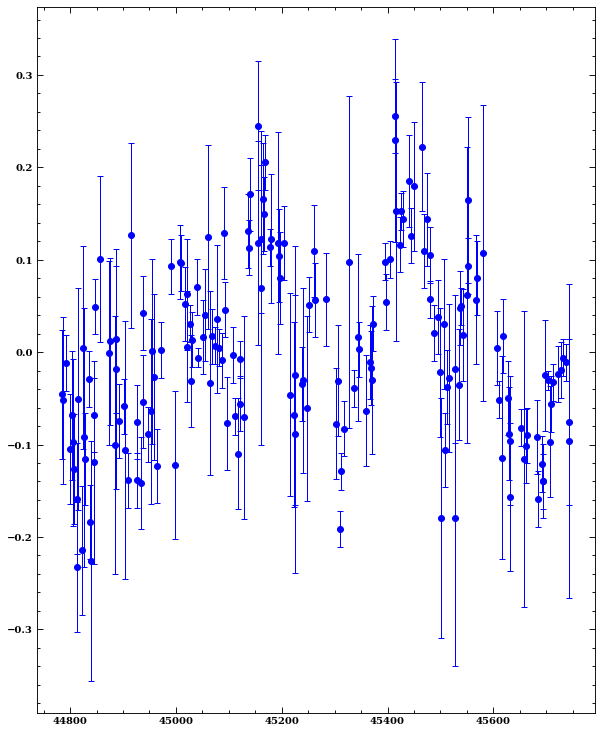

In [54]:
fig, ax = plt.subplots(figsize=(10,13))
# ax.errorbar(Day1,Flux1,yerr=Flux_err1,
#                  fmt='o', label="{} GHZ".format(freq),color="k",)
ax.errorbar(Day1,Flux1 - (flux_scale1[0] * p_hat1 + flux_scale1[1]),
            yerr=Flux_err1,
     fmt='o', label="{} GHz No Lens".format(freq),color="b")

np.savetxt("SAV1_8Ghz_residual.csv", np.stack([Day1,Flux1 - (flux_scale1[0] * p_hat1 + flux_scale1[1]), 
                                          Flux_err1]).T, delimiter=",")

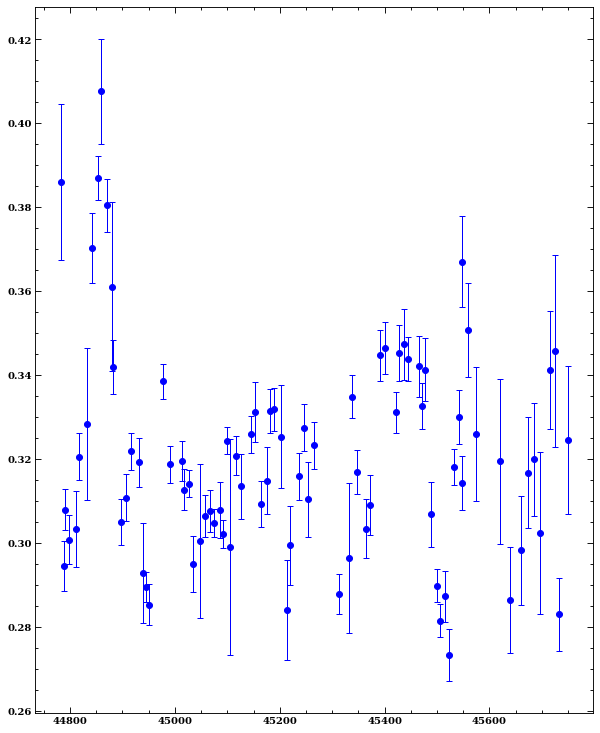

In [102]:
fig, ax = plt.subplots(figsize=(10,13))

ax.errorbar(Day1,(Flux1 - flux_scale1[1])/p_hat1 + flux_scale1[1], 
            yerr=Flux_err1/p_hat1,
     fmt='o', label="{} GHz No Lens".format(freq),color="b")

np.savetxt("SAV45_residual.csv", np.stack([Day1,(Flux1 - flux_scale1[1])/p_hat1 + flux_scale1[1], 
                                          Flux_err1/p_hat1]).T, delimiter=",")

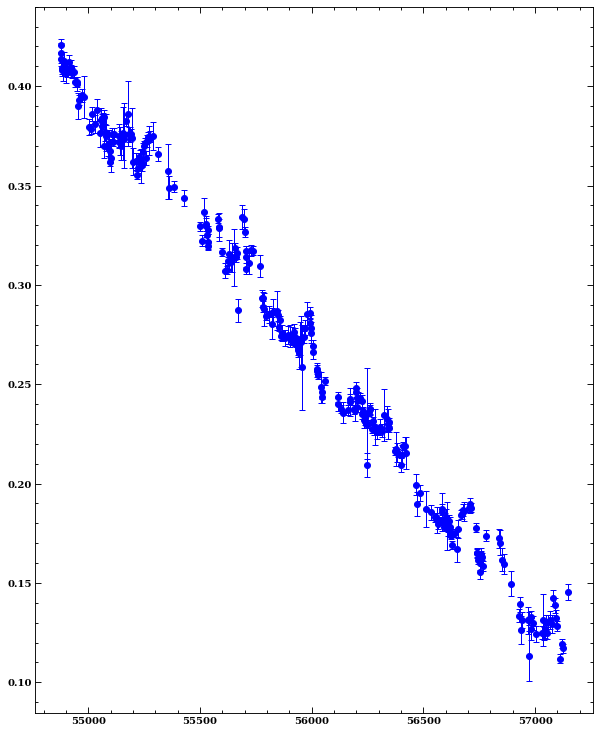

In [58]:
fig, ax = plt.subplots(figsize=(10,13))

# ax.errorbar(Day_current,Data_current[1], yerr=Data_current[2],
#      fmt='o', label="{} GHz No Lens".format(freq),color="r")

# ax.errorbar(Day_current,flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2 + flux_scale1[2], yerr=Data_current[2],
#      fmt='o', label="{} GHz No Lens".format(freq),color="b")

scale = ((flux_scale1[0] * p_hat1 + flux_scale1[1] * p_hat2) / (flux_scale1[0] + flux_scale1[1]))
ax.errorbar(Day_current,(Data_current[1] - flux_scale1[2])/scale
            + flux_scale1[2] 
            + (Day_current * slope[15.0] + y_int[15.0]-0.505),
            yerr=Data_current[2]/scale,
     fmt='o', label="{} GHz No Lens".format(freq),color="b")

np.savetxt("SAV45_unlensed_total2.csv", np.stack([Day_current,(Data_current[1] - flux_scale1[2])/scale
            + flux_scale1[2] + (Day_current * slope[15.0] + y_int[15.0]-0.505),
                                                 Data_current[2]/scale]).T, delimiter=",")

<Container object of 3 artists>

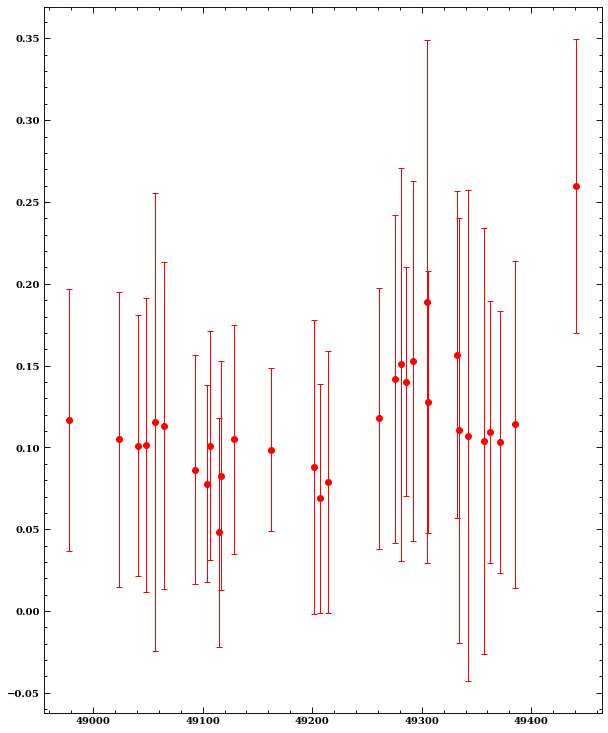

In [100]:
fig, ax = plt.subplots(figsize=(10,13))

# ax[i].plot(Day, flux_scale1[0] * p_hat_plot1 + flux_scale1[1] * p_hat_plot2 + flux_scale1[2] 
#       , alpha=0.4, color='r',zorder=10,linestyle="-")

ax.errorbar(Day1,(Flux1 - flux_scale1[1])/p_hat1 + flux_scale1[1], yerr=Flux_err1,
     fmt='o', label="{} GHz No Lens".format(freq),color="r")

In [12]:
Flux1.shape

(14,)

In [13]:
np.stack((Flux1,np.ones(len(Flux1)))).shape

(2, 14)

In [20]:
U,S,V = np.linalg.svd(np.stack((p_hat1,np.ones(len(p_hat1)),Flux1)).T)

In [22]:
V.shape

(3, 3)

In [23]:
a = - V[:2,2] / V[2,2]

In [42]:
X = np.stack((p_hat1,np.ones(len(p_hat1)))).T
Xy = np.stack((p_hat1,np.ones(len(p_hat1)),Flux1)).T
Xtyt = - Xy @ np.outer(V[:,2], V[:,2])
Xt = Xtyt[:,:2]

In [32]:
V[:2,2].shape

(2,)

In [29]:
X.T.shape

(2, 14)

In [30]:
V.shape

(3, 3)

In [ ]:
A = 
x = np.linalg.lstsq(A,Day1)

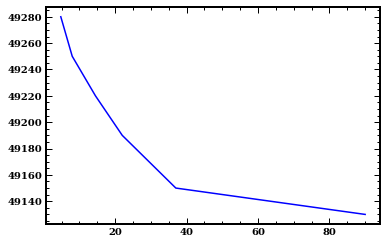

In [28]:
y = [49280, 49250,49220,49190,49150,49130]
x = np.array([4.8,8.0,14.5,22.0,37.0,90.0])
plt.plot(x,y,color="b")

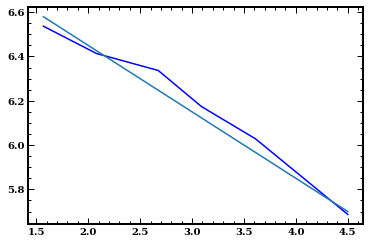

In [12]:
y = np.log([abs(48935 - 49625), abs(48935 - 49545), abs(48935 - 49500), abs(48955 - 49435),abs(48955 - 49370),abs(48955 - 49250)])
x = np.log(np.array([4.8,8.0,14.5,22.0,37.0,90.0]))
plt.plot(x,y,color="b")
plt.plot(x,-0.3*x+7.05)


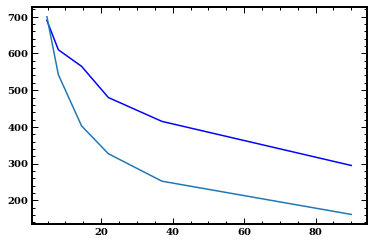

In [30]:
y = [abs(48935 - 49625), abs(48935 - 49545), abs(48935 - 49500), abs(48955 - 49435),abs(48955 - 49370),abs(48955 - 49250)]
x = np.array([4.8,8.0,14.5,22.0,37.0,90.0])
plt.plot(x,y,color="b")
plt.plot(x,700/(4.8**(-0.5))*x**(-0.5))


In [2]:
from scipy.optimize import minimize_scalar

In [4]:
x = np.array([1,2,3,4,5,6,3,4,2,3,6,3,4,0,9,20,50,3,6,2,9,7,4,500])
print(np.median(x))
print(np.mean(x))

res = minimize_scalar(lambda m: np.sum(abs(x - m))/len(x), bounds=(min(x),max(x)),method="bounded")
print(res["x"])

4.0
27.333333333333332
4.0000009796681315


In [51]:
np.einsum("ji,i-> i",smooth,np.ones(500)).shape

(500,)

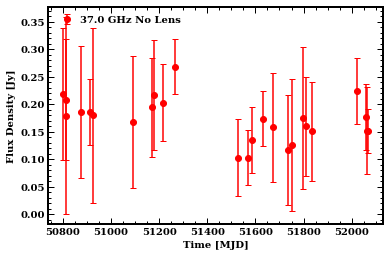

In [25]:
plt.errorbar(Day1,(Flux1 - flux_scale1[1])/p_hat1 + flux_scale1[1], yerr=Flux_err1,
                 fmt='o', label="{} GHz No Lens".format(freq),color="r")
leg = plt.legend(loc = 2,)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.xlabel(r"Time [MJD]",fontweight="bold")
plt.ylabel(r"Flux Density [Jy]",fontweight="bold")
plt.savefig("plots/" + "zoom_in_SAV3" + ".pdf",format="pdf")